# Comandos específicos do Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install inflection

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install boruta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 56 kB 2.4 MB/s 


In [4]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **Importando as bibliotecas**

In [5]:
import math
import numpy  as np
import pandas as pd

import inflection

import seaborn as sns

import datetime

import random

import pickle

from matplotlib import pyplot as plt
from IPython.core.display import HTML
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error

from boruta import BorutaPy

import xgboost as xgb

## **Funções Auxiliares**

Segue abaixo uma função que serve para melhorar a aparência dos gráficos que aparecerão:

In [6]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [7]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Feito isso, também definiremos uma função que calcula os erros MAE (mean absolute error), MAPE (mean absolute percentage error) e RMS (root mean square), retornando uma tabela contendo essas informações. 

In [8]:
def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )
     
    
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

    
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

Para a validação cruzada, usaremos a seguinte função:

In [9]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    
    mae_list = []
    mape_list = []
    rmse_list = []
    
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
            
        # Começo e fim da data de validação 
        # é 6*7 pois são 6 semanas (6 x 7 dias)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)

        # Seleção do "subtreino" e dados da validação
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        
        # training
        xtraining = training.drop(columns = ['date', 'sales']) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( columns = ['date', 'sales'])
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )



## **Carregando os dados**

Para carregar os dados, usaremos a função `read_csv` como de costume, mas configuraremos o parãmetro `low_memory` como `False` para não haver uma mistura com relação à tipagem das variáveis.

In [10]:
# df_sales_raw = pd.read_csv( 'train.csv', low_memory=False )

# df_store_raw = pd.read_csv( 'store.csv', low_memory=False )

df_sales_raw = pd.read_csv( '/content/drive/MyDrive/Colab Notebooks/train.csv', low_memory=False )

df_store_raw = pd.read_csv( '/content/drive/MyDrive/Colab Notebooks/store.csv', low_memory=False )


Vejamos a cara dessas tabelas.

In [11]:
df_sales_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [12]:
df_store_raw.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


Queremos juntar os dados dessas tabelas para que fique mais simples de elaborar o modelo. Para isso, usamos a função `merge` do pandas, cuja documentação está [neste link](https://pandas.pydata.org/docs/reference/api/pandas.merge.html#pandas.merge). 

Dentre os parâmetros que ela possui, destacamos:

* `left`: tabela que ficará "à esquerda" depois da junção.

* `right`: tabela que ficará "à direita" depois da junção.

* `how`: Tipo de junção a ser executada. As opções disponíveis são `left`, `right`, `inner`, `outer` e `cross`; que são similares às junções no SQL. No nosso caso escolheremos a junção `left`, onde a chave comum às duas tabelas é a coluna "Store". Deste modo, para cada linha da tabela de vendas, adicionaremos colunas associadas aos dados daquela loja em específico.

* `on`: é o nome da coluna que deve constar em ambas as tabelas para servir como chave.

In [13]:
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

Para ver como a tabela ficou, basta digitar

In [14]:
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# **PARTE 1: DESCRIÇÃO DOS DADOS**

Antes de descrever os dados em si, vamos primeiramente fazer uma cópia da tabela por segurança.

In [15]:
df1 = df_raw.copy()

## **Renomeando as Colunas**

Para trocar o nome das colunas, usamos a função `underscore` para transformar do formato Camel Case para o snake case, onde as palavras são separadas por underlines.

In [16]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

# rename
df1.columns = cols_new

Para checar, basta digitar

In [17]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## **Dimensão dos Dados**

Vejamos quantas linhas e colunas nossa tabela possui.

In [18]:
print("Número de linhas:", df1.shape[0])

print("Número de colunas:", df1.shape[1])

Número de linhas: 1017209
Número de colunas: 18


## **Tipagem das colunas**

Antes de ver qual o tipo das variáveis que temos, transformemos a coluna das datas, que está como string, no formato `datetime`. Como ela está escrita do jeito "aaaa-mm-dd", então é só usar a função `to_datetime`, cuja documentação se encontra [neste link](https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html).

In [19]:
df1['date'] = pd.to_datetime(df1['date'], format = '%Y-%m-%d')

Agora sim vejamos a tipagem das colunas com o atributo `dtypes`.

In [20]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## **Verificando Células Vazias**

Para checar as células vazias, usamos o método `isna()`, que retorna um DataFrame cujas células são variáveis booleanas indicando se está vazia ou não, seguido do método `sum()`, que retorna um valor correspondente à soma das células das colunas. No fim, teremos uma tabela com duas colunas, sendo a primeira o nome das colunas da tabela original, e a segunda é o número de NaN's que esta coluna tem.

In [21]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## **Preenchimento das células vazias**

### **Distância do concorrente**

Para a distância do concorrente mais próximo, vamos dizer que este está a 200 mil metros para os valores nulos. Em outras palavras, a distância é tão grande que na prática não existe concorrência.

In [22]:
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

### **Mês de Abertura da concorrência**

Para o mês de abertura do concorrente mais próximo, diremos que esta é o mesmo mês de abertura da drogaria Rossman mais próxima.

In [23]:
list(df1['competition_open_since_month'].unique())

[9.0, 11.0, 12.0, 4.0, 10.0, 8.0, nan, 3.0, 6.0, 5.0, 1.0, 2.0, 7.0]

In [24]:
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else
                                                           x['competition_open_since_month'], axis=1 )


Vejamos se agora se o `nan` sumiu.

In [25]:
list(df1['competition_open_since_month'].unique())

[9.0, 11.0, 12.0, 4.0, 10.0, 8.0, 7.0, 3.0, 6.0, 5.0, 1.0, 2.0]

### **Ano de abertura da concorrência**

Para o ano de abertura da concorrência, faremos o mesmo que no item anterior.

In [26]:
def AnoAbertura(x):
    if math.isnan(x['competition_open_since_year']):
        resultado = x['date'].year
    else:
        resultado = x['competition_open_since_year']
        
    return resultado

df1['competition_open_since_year'] = df1.apply( AnoAbertura, axis=1 )

### **Prom2**

Procederemos da mesma maneira com relação às promoções consecutivas.

In [27]:
#promo2_since_week           
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) 
                                                else x['promo2_since_week'], axis=1 )

#promo2_since_year           
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) 
                                                else x['promo2_since_year'], axis=1 )

### **Intervalo de promoções**

Para o intervalo de promoções consecutivas, vamos preencher com 0 para as células nulas.

In [28]:
df1['promo_interval'].fillna(0, inplace=True )

## **Criando uma nova coluna**

Antes de criar uma nova coluna, note que o atributo `dt.month` é o dígito correspondente ao mês, isto é, 1 para Janeiro, 2 para Feveiro, e assim por diante até 12 (Dezembro).

Aqui iremos escolher uma amostra de 5 linhas senão teríamos todas as linhas possíveis na saída.

In [29]:
df1['date'].dt.month.sample(5)

617364    12
251290    12
9897       7
501213     4
269929    11
Name: date, dtype: int64

Como na tabela original está na forma de dígitos, e queremos trocar pelaas strings de seus respectivos meses, então criemos primeiramente um dicionário contendo essas informações.

In [30]:
month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',
             7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

Para realizar essa troca, usamos o método `map`, inserindo esse dicionário como argumento.

In [31]:
df1['month_map'] = df1['date'].dt.month.map( month_map )

Checando se está tudo certo.

In [32]:
df1['month_map'].sample(4)

397542    Jul
587158    Jan
269942    Nov
621402    Dec
Name: month_map, dtype: object

Feito isso, criemos uma coluna cujas células são 0 caso não tenha uma promoção naquele mês, e 1 caso contrário.

In [33]:
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 
                                                             else 1 if x['month_map'] in x['promo_interval'].split( ',' ) 
                                                             else 0, axis=1 )

Feito todos esse ajustes, verifiquemos se ainda restou alguma célula vazia.

In [34]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## **Descrição Estatística dos dados**

### **Atributos Numéricos**

Uma vez terminado o preenchimento de células vazias, vamos analisar os atributos, começando pelos numéricos.

In [35]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )

A ideia nesta seção é elaborar uma tabela que contenha os seguintes parâmetros de cada coluna:

* Média

* Mediana

* Desvio Padrão

* Valor mínimo

* Valor máximo

* Variação

* Skew

* Kurtosis

#### **Média**

In [36]:
ct1 = pd.DataFrame(num_attributes.apply(np.mean), columns = ['mean'])

ct1

,mean
store,558.429727
day_of_week,3.998341
sales,5773.818972
customers,633.145946
open,0.830107
promo,0.381515
school_holiday,0.178647
competition_distance,5935.442677
competition_open_since_month,6.786849
competition_open_since_year,2010.324840


#### **Mediana**

In [37]:
ct2 = pd.DataFrame(num_attributes.apply(np.median), columns = ['median'])

ct2

,median
store,558.0
day_of_week,4.0
sales,5744.0
customers,609.0
open,1.0
promo,0.0
school_holiday,0.0
competition_distance,2330.0
competition_open_since_month,7.0
competition_open_since_year,2012.0


#### **Desvio Padrão**

In [38]:
d1 = pd.DataFrame( num_attributes.apply( np.std ), columns = ['std'] ) 

#### **Mínimo, Máximo e Variação**

In [39]:
d2 = pd.DataFrame( num_attributes.apply( min ), columns = ['min'] ) 

d3 = pd.DataFrame( num_attributes.apply( max ), columns = ['max'] ) 

d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ), columns = ['range'] )

#### **Skew e Kurtosis**

In [40]:
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ), columns = ['skew'] )

d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ), columns = ['kurtosis'] )

#### **Juntando os dados**

Para juntar essas informações numa única tabela, basta usar a função `concat` do pandas.

In [41]:
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6], axis = 'columns' )

m

,min,max,range,mean,median,std,skew,kurtosis
store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


Para visualizarmos a distância do concorrente mais próximo, podemos fazer um distplot com o auxílio do seaborn.

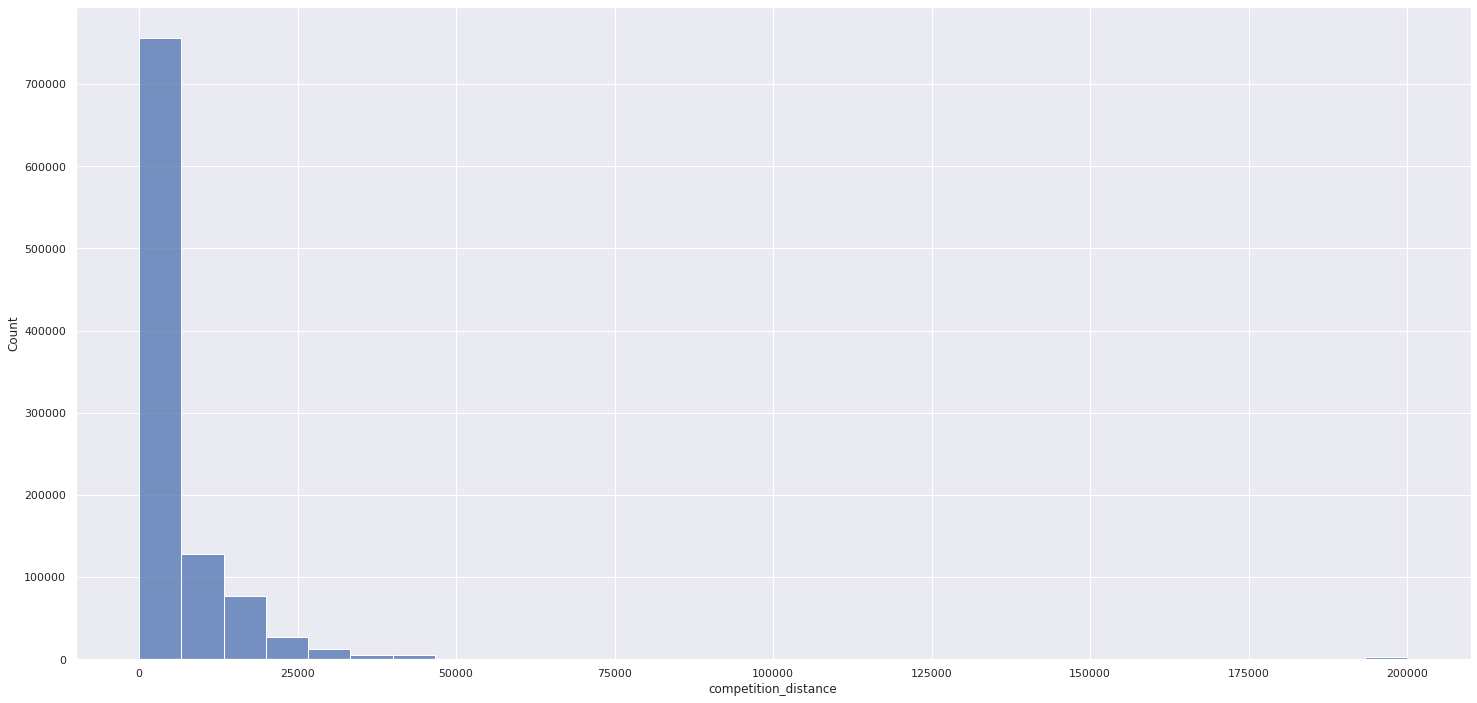

In [42]:
sns.histplot( x = df1['competition_distance'], kde=False, bins = 30 )

### **Atributos Categóricos**

Agora vejamos os atributos categóricos.

In [43]:
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

Para ver quantas "respostas" existem em cada coluna, usamos a seguinte linha de comando.

In [44]:
cat_attributes.apply( lambda x: len(x.unique()) )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

O `unique()` retorna uma lista com todos os elementos possíveis da coluna. Como queremos saber o tamanho dessa lista, é só aplicar a função `len()`.

Para visualizarmos esses atributos, definamos uma tabela auxiliar que contenha apenas dados de dias que sejam feriados e com vendas maiores que 0.

In [45]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

Agora sim realizemos os gráficos do tipo boxplot:

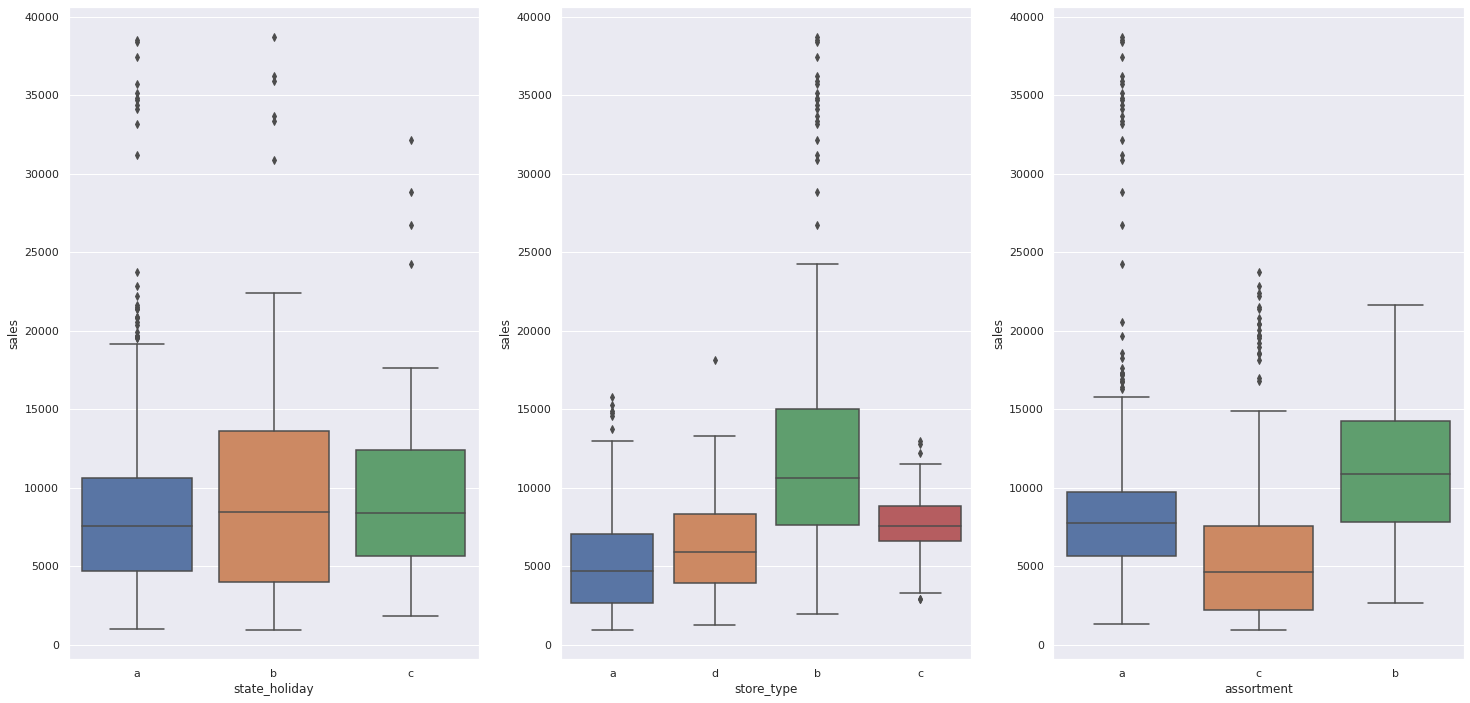

In [46]:
plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux )

# **PARTE 2: EXTRAÇÃO DE CARACTERÍSTICAS**

Nesta parte vamos extrair algumas características de nossa tabela, agora que já tratamos células nulas e fizemos uma descrição estatística dos atributos numéricos e categóricos.

In [47]:
df2 = df1.copy()

## **Formulação de Hipóteses**

Considerando os aspectos: Loja, Produto e Tempo; então podemos criar as seguintes hipóteses:

### **Hipóteses da Loja**

**1.** Lojas com número maior de funcionários deveriam vender mais, pois possuem mais pessoas para oferecer os produtos.

**2.** Lojas com maior capacidade de estoque deveriam vender mais, dado que elas teriam mais produtos a serem vendidos.

**3.** Lojas com maior porte deveriam vender mais devido ao seu tamanho.

**4.** Lojas com maior sortimentos deveriam vender mais, porque produtos mais organizado costumam chamar mais clientes.

**5.** Lojas com concorrentes mais próximos deveriam vender menos, pois o mercado consumidor estaria agora divido entre uma drogaria Rossman e o concorrente.

**6.** Lojas com concorrentes a mais tempo deveriam vender mais, pois a disputa de clientes chegou num estado estacionário.

### **Hipóteses do Produto**

**1.** Lojas que investem mais em Marketing deveriam vender mais. Dispensa justificativa.

**2.** Lojas com maior exposição de produto deveriam vender mais. Dispensa justificativa.

**3.** Lojas com produtos com preço menor deveriam vender mais, pois são mais acessíveis ao público.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais. Dispensa justificativa.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais, pois os produtos estariam mais acessíveis por mais tempo.

**7.** Lojas com mais dias de promoção deveriam vender mais. A justificativa é a mesma do item anterior.

**8.** Lojas com mais promoções consecutivas deveriam vender mais. Dispensa justificativa.

### **Hipóteses com relação ao tempo**

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais, pois Natal é uma época em que há mais comércio em geral.

**2.** Lojas deveriam vender mais ao longo dos anos, talvez devido ao processo de fidelização e captação de clientes.

**3.** Lojas deveriam vender mais no segundo semestre do ano. Verificar hipótese com a análise exploratória de dados.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês. Verificar hipótese com a análise exploratória de dados.

**5.** Lojas deveriam vender menos aos finais de semana, pois os consumidores estariam em outros tipos de estabelecimentos como restaurante.

**6.** Lojas deveriam vender menos durante os feriados escolares, pois os pais estariam viajando com os filhos.

### **Lista Final de Hipóteses**

Segue abaixo as hipóteses que podemos verificar com a tabela que temos.

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**9.** Lojas deveriam vender mais ao longo dos anos.

**10.** Lojas deveriam vender mais no segundo semestre do ano.

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos aos finais de semana.

**13.** Lojas deveriam vender menos durante os feriados escolares.

## **Extração de características propriamente ditas**

Para verificar essas hipóteses, criemos primeiramente colunas que contenham apenas a informação desejada. Por exemplo, no caso das hipóteses envolvendo o tempo, extrairemos os valores como ano, mês e dia.

### **Tempo**

Note que o atributo `dt.year`, de acordo com a bilbioteca `datetime`, retorna o número correspondente ao ano da célula. Assim, criemos uma coluna apenas contendo o ano envolvendo as vendas realizadas.

In [48]:
df2['date'].dt.year.sample(5)

315566    2014
855196    2013
617487    2013
919496    2013
383276    2014
Name: date, dtype: int64

In [49]:
df2['year'] = df2['date'].dt.year

Fazendo a mesma coisa para o dia e o mês, temos

In [50]:
df2['month'] = df2['date'].dt.month

df2['day'] = df2['date'].dt.day

Para a n-ésima semana do ano, usamos o atributo `weekofyear`.

In [51]:
df2['date'].dt.weekofyear.sample(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """Entry point for launching an IPython kernel.


252019    51
226791     2
417889    25
877147    19
948286     9
Name: date, dtype: int64

Assim, temos

In [52]:
df2['week_of_year'] = df2['date'].dt.weekofyear

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """Entry point for launching an IPython kernel.


Será útil criarmos uma coluna que contenha uma variável do tipo `datetime` com o ano e o número da semana. Isso é feito com o método `strftime()`, e no argumento colocamos `%Y-%W`, indicando que o primeiro valor será o ano, e o segundo é o número da semana.

In [53]:
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

### **Concorrência**

Vamos começar criando uma coluna que represente a data de abertura do concorrente. Como não temos a informação do dia, então tomaremos como sendo o dia 1 do mês.

In [54]:
df2['competition_open_since_month'] = df2['competition_open_since_month'].astype(int)
df2['competition_open_since_year'] = df2['competition_open_since_year'].astype(int)

df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], 
                                                                   month=x['competition_open_since_month'],day=1 ), axis=1 )

Também é útil saber há quanto tempo temos uma concorrência (contando a partir da data que está na coluna 'date'), que seria a diferença de `df2['date']` e `df2['competition_since']`, o que retorna o objeto `timedelta` medido em dias. Dado que esse número pode ser grande, vamos converter para meses, o que significa que é preciso dividir por 30.

In [55]:
( ( df2['date'] - df2['competition_since'] )/30 ).sample(5)

816225    74 days 00:48:00
732572     0 days 09:36:00
697038    92 days 20:00:00
811955    26 days 12:00:00
891666   -4 days +16:00:00
dtype: timedelta64[ns]

O que queremos do objeto `timedelta` é o atributo `days`, mesmo que tenhamos convertido em meses. Assim, podemos selecionar esse atributo com o método `apply`.

In [56]:
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

Obs: fizemos a conversão para o tipo `int` pois o resultado estava como `float`.

### **Feriado e Organização**

Como as modificações que faremos com relação ao feriado e à organização dos produtos são similares, então colocamos num mesmo tópico. 

Para a organização dos produtos, diremos, conforme o enunciado do Kaggle, que o resultado `a` significa `basic`, que o `b` significa `extra` e que `c` é o `extended`.

In [57]:
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a'
                                                       else 'extra' if x == 'b' 
                                                       else 'extended' )

Com respeito aos feriados, também foi dado no enunciado que `a` é um feriado público, `b` é páscoa, `c` é Natal, e `d` é um dia normal, sem feriado.

In [58]:
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 
                                                             'easter_holiday' if x == 'b' else 
                                                             'christmas' if x == 'c' else 
                                                             'regular_day' )

### **Promo2**

Para sabermos quanto tempo durou a promoção, quando houve, executamos os seguintes comandos:

In [59]:
df2['promo2_since_year'] = df2['promo2_since_year'].astype(int)

df2['promo2_since_week'] = df2['promo2_since_week'].astype(int)

df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )

df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) 
                                                          - datetime.timedelta( days=7 ) )

df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )


# **PARTE 3: FILTRAGEM DOS DADOS**

In [60]:
df3 = df2.copy()

Antes de começar a análise exploratória de dados, precisamos filtrar quais linhas e colunas gostaríamos de processar. Começando pelas linhas, gostaríamos de analisar dados de lojas que estavam abertas no dia e que tiveram vendas:

In [61]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

Com respeito às colunas, já usamos direta ou indiretamente as colunas `open` quando descartamos as lojas que estavam fechadas, `promo_interval` e `month_map` quando criamos a coluna `is_promo`.

Além disso, também vamos descartar a coluna `customers` pois não temos como prever quantos consumidores haverão nas próximas 6 semanas.

In [62]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

df3 = df3.drop( columns = cols_drop)

# **PARTE 4: ANÁLISE EXPLORATÓRIA**

Neste módulo faremos uma análise exploratória dos dados e verificar a veracidade das hipóteses feitas no módulo anterior. Vamos iniciar criando uma cópia da tabela de dados.

In [63]:
df4 = df3.copy()

Antes de verificar as hipóteses em si, vejamos um histograma com relação ao valor das vendas feitas em cada linha da tabela.

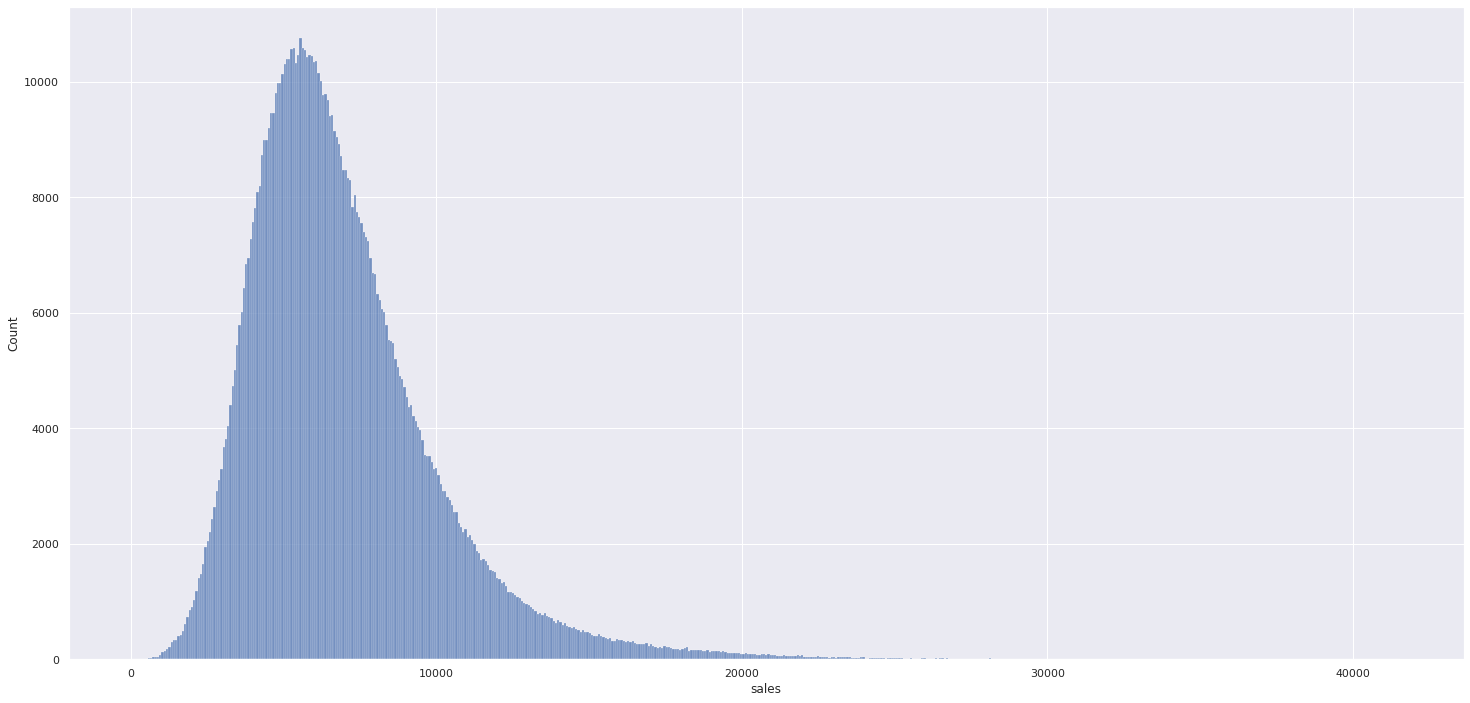

In [64]:
sns.histplot(data = df4, x = 'sales')

Como podemos ver, as vendas parecem seguir a [distribuição da Maxwell_Boltzmann](https://pt.khanacademy.org/science/physics/thermodynamics/temp-kinetic-theory-ideal-gas-law/a/what-is-the-maxwell-boltzmann-distribution) por conta da assimetria. Além disso, a média diária de vendas está entre 0 e 10000. 

Agora vejamos histogramas relacionados aos atributos numéricos.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb789c54b50>,
      dtype=object)

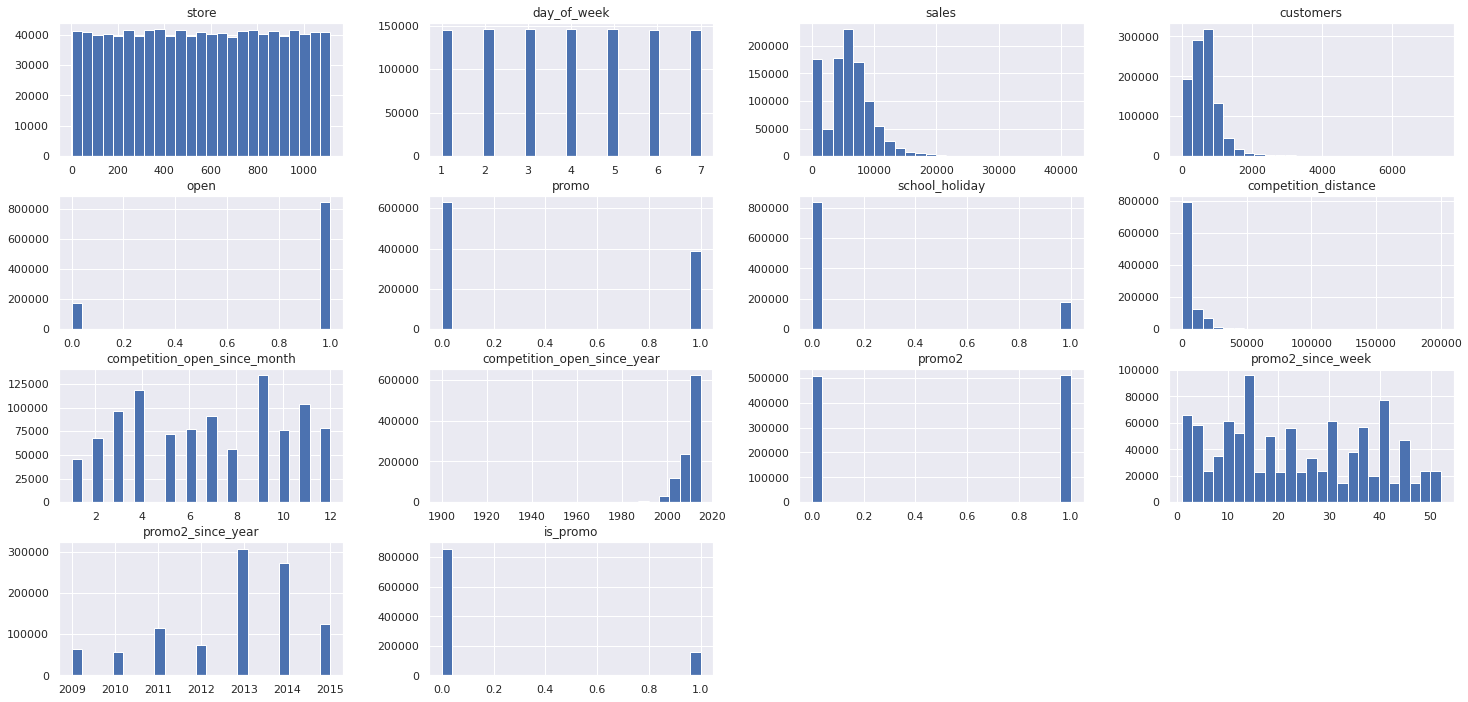

In [65]:
num_attributes.hist(bins = 25)

Com respeito aos atributos categóricos, faremos 3 subplots sobre o valor das vendas. Começando pelo tipo de feriado, note que nos três tipos de feriados, o valor médio das vendas continua similar ao dos outros dias em geral.

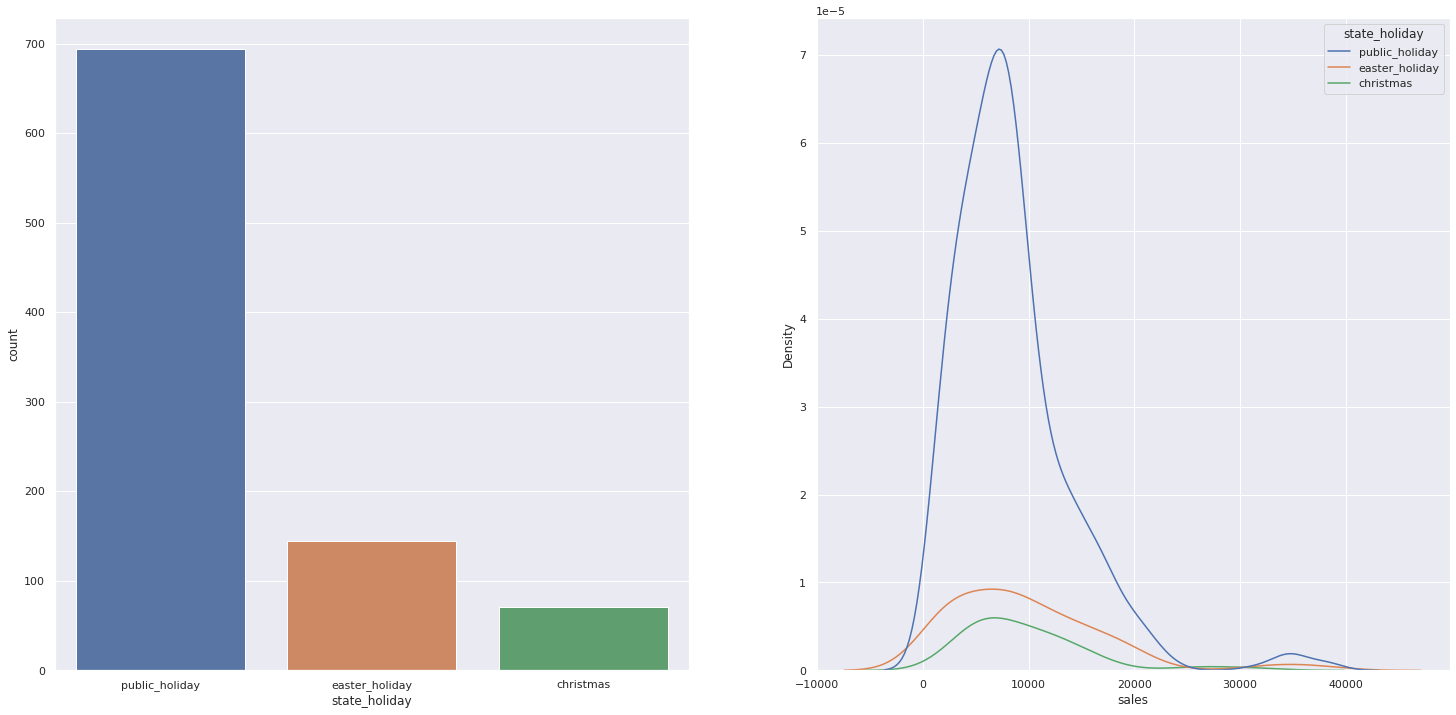

In [66]:
a = df4[ df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
sns.countplot(x = a['state_holiday'])

plt.subplot(1,2,2)
sns.kdeplot( data = a , x = 'sales', hue = 'state_holiday' )

Agora vejamos as vendas com relação ao tipo de loja. Perceba que as lojas do tipo 'b' possuem uma quantidade considerável de vendas entre 10000 e 20000 (depois do pico), pois sua estimativa de densidade decresce de forma menos abrupta do que as lojas do tipo 'a','c' e 'd'.

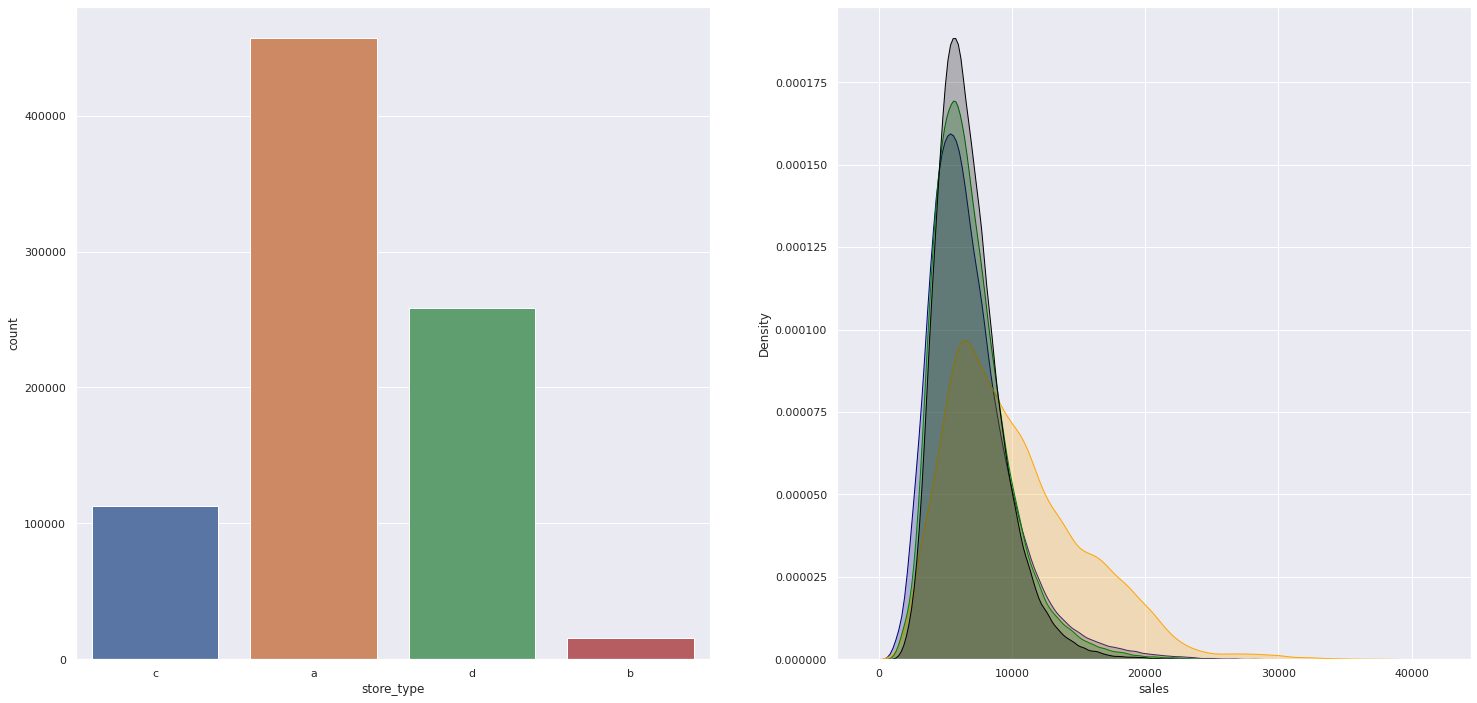

In [67]:
plt.subplot( 1, 2, 1 )
sns.countplot(x = df4['store_type'] )

plt.subplot( 1, 2, 2 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', fill=True, color = 'navy' )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', fill=True, color = 'orange' )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', fill=True, color = 'green' )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', fill=True, color = 'black' )


Por fim, vejamos como a relação entre o tipo de organização dos produtos e as vendas. Aqui é possível visualizar que o número de vendas ainda é "firme" para as lojas cuja organização de produtos é do tipo "extra", pois sua estimativa de densidade decresce de forma menos abrupta do que as outras categorias.

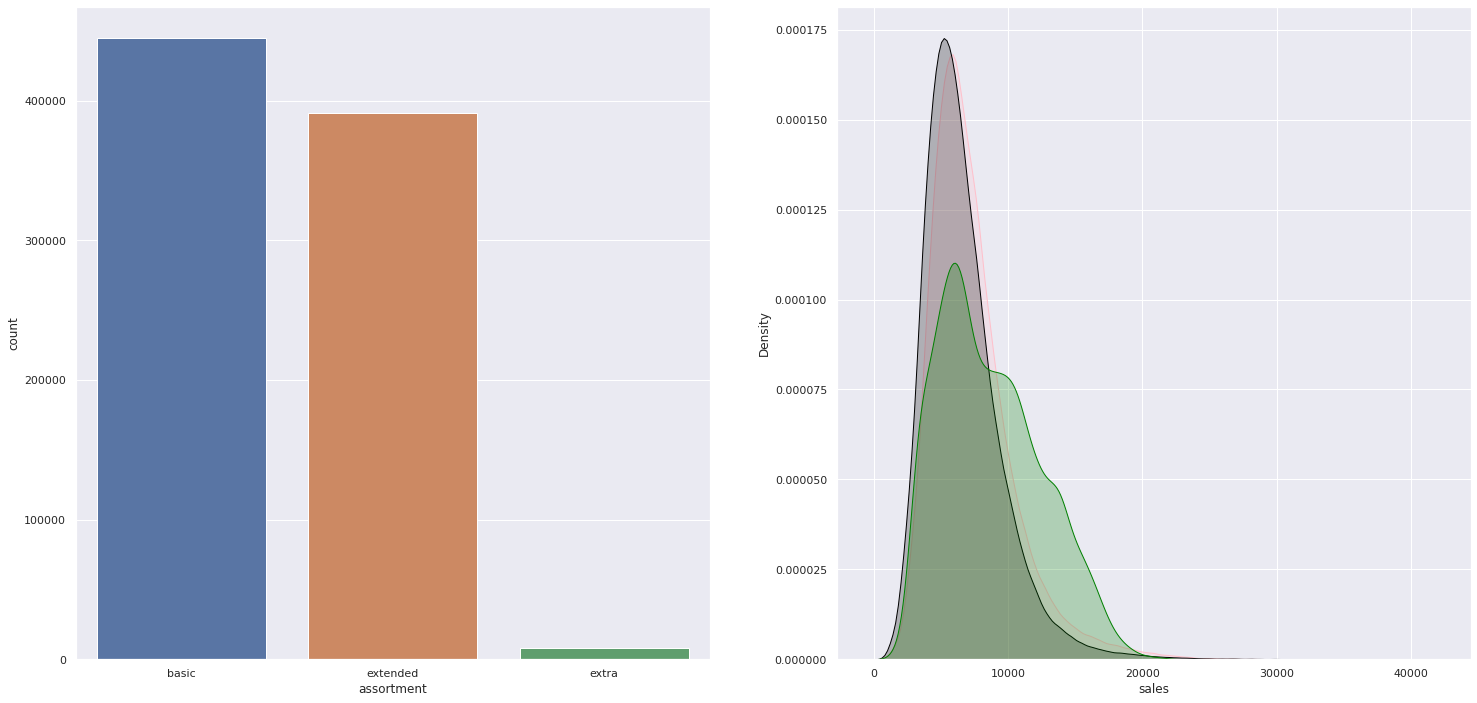

In [68]:
plt.subplot( 1, 2, 1 )
sns.countplot(x = df4['assortment'] )

plt.subplot( 1, 2, 2 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True , color = 'pink')
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True, color = 'black' )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True, color = 'green' )

## **Análise Bivariada**

Aqui iremos verificar as hipóteses realizadas realizando alguns gráficos.

### **Hipótese 1 (FALSA): Lojas com maior sortimento deveriam vender mais**

Para verificar essa hipótese, vamos criar uma tabela que contenha o valor total das vendas das lojas com cada tipo de sortimento.

In [69]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum()

aux1

,sales
assortment,
basic,2945750070
extended,2856484241
extra,70946312


O faturamento das lojas com o sortimento "extra" é consideravelmente menor que o dos outros pois também há menos amostras dela, vide o gráfico anterior. Além disso, o faturamento total das lojas com sortimento "basic" é maior que o "extended". Como o número de amostras é relativamente parecido, isso já nos sugere que a hipótese esteja errada.

Para confirmar, façamos um gráfico com a variação das vendas ao longo do tempo para cada tipo de sortimento. Vamos começar criando uma tabela que nos dê o total de vendas de cada tipo de sortimento para cada semana do ano.

In [70]:
aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week','assortment'] ).sum().reset_index()

aux2.head(5)

,year_week,assortment,sales
0,2013-00,basic,13434262
1,2013-00,extended,12425669
2,2013-00,extra,269404
3,2013-01,basic,26007250
4,2013-01,extended,22917693


Agora separemos o tipo de sortimento em colunas distintas.

In [71]:
auxx = aux2.pivot( index='year_week', columns='assortment', values='sales' )

auxx.head()

assortment,basic,extended,extra
year_week,,,
2013-00,13434262,12425669,269404
2013-01,26007250,22917693,350279
2013-02,17970974,16029584,377207
2013-03,24392076,21243431,404662
2013-04,19972891,18130077,363061


Com isso podemos fazer o gráfico simplesmente com o método `plot()`.

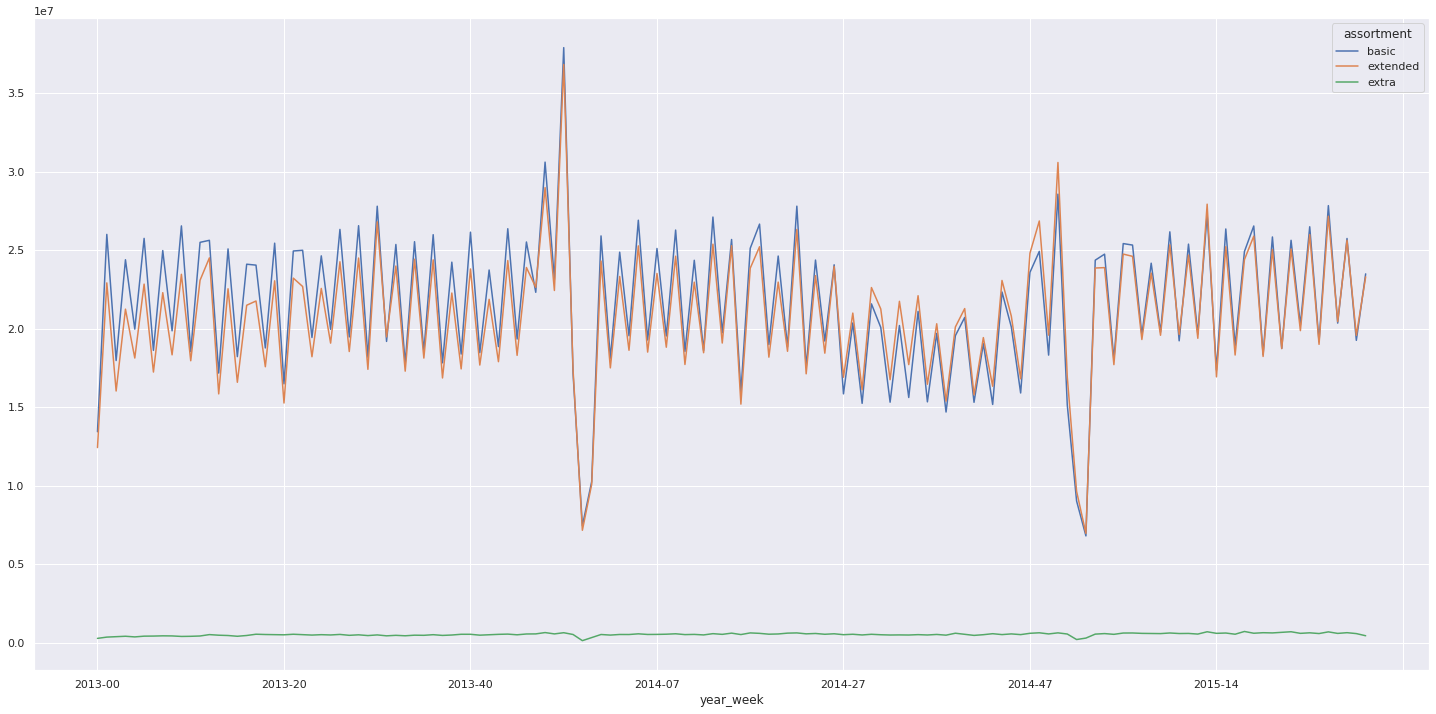

In [72]:
auxx.plot()

Vendo a variação temporal, de fato o sortimento do tipo "basic" é maior que o do tipo "extended" na maior parte do tempo. Portanto, a nossa hipótese é **FALSA**.

### **Hipótese 2 (FALSA): Lojas com competidores mais próximos deveriam vender menos**

Para verificar isso, selecionemos primeiramente os dados de vendas e distância do concorrente mais próximo, e agrupemos através da variável de distância.

In [73]:
aux1 = df4[['sales', 'competition_distance']].groupby(by = 'competition_distance').sum().reset_index()

aux1.sample(5)

,competition_distance,sales
85,910.0,10490700
612,22350.0,4430153
350,5090.0,2405374
387,6260.0,3315479
151,1700.0,18930319


A ideia para verificar essa hipótese é fazer um gráfico de dispersão onde o eixo x é a distância e o y corresponde às vendas.

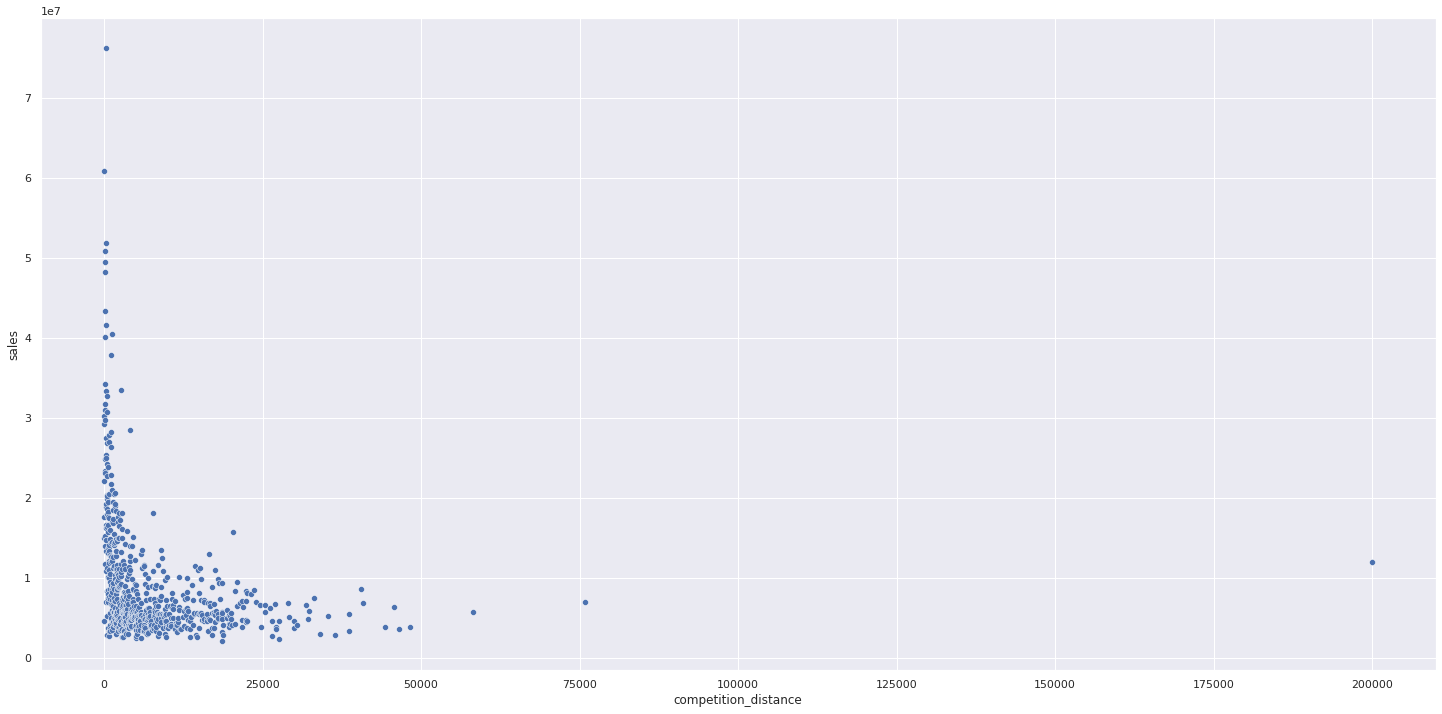

In [74]:
sns.scatterplot(data = aux1, x ='competition_distance', y='sales')

Com isso, podemos ver que as vendas caem drasticamente com o aumento da distância. Portanto, nossa hipótese é **FALSA**.

### **Hipótese 3 (FALSA): Lojas com concorrentes há mais tempo deveriam vender mais**

Verifiquemos se as drogarias com concorrentes há mais tempo possuem mais vendas. Para tal, precisamos agrupar os dados da coluna `competition_time_month`.

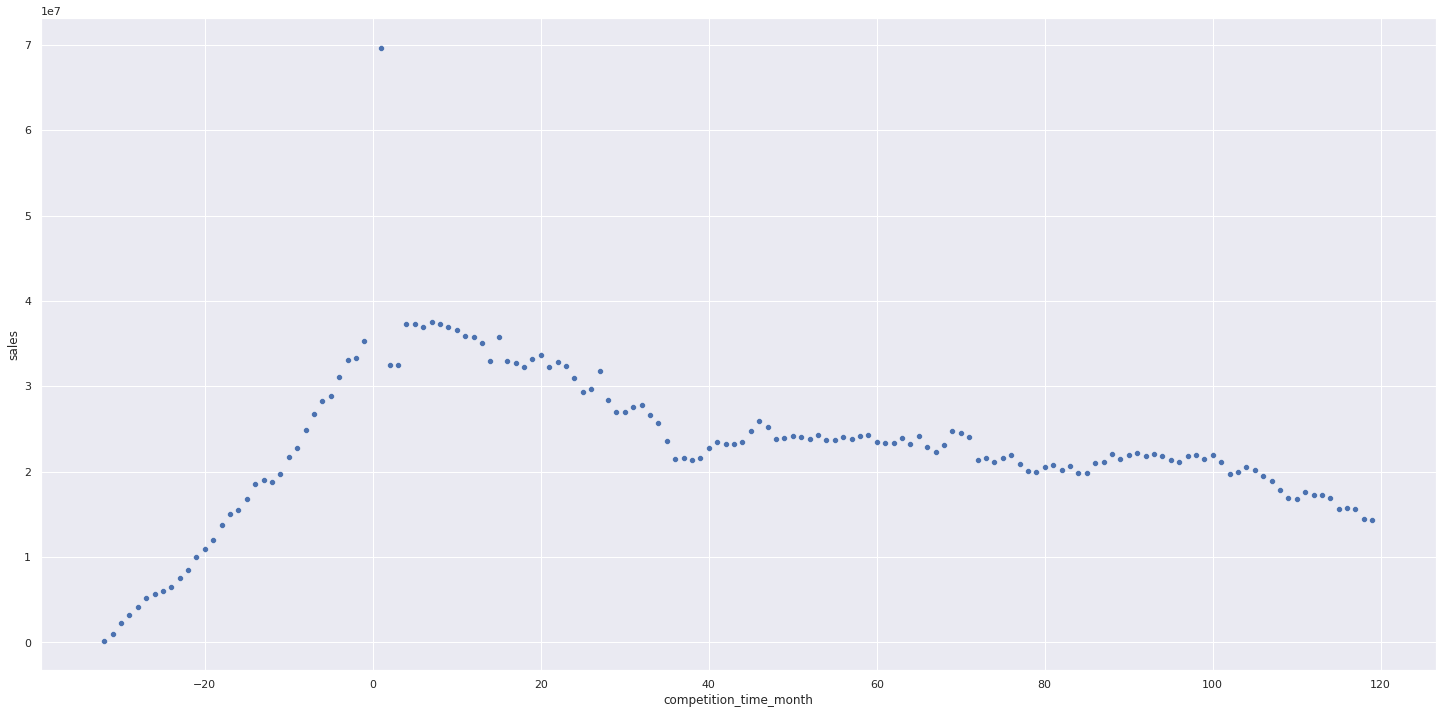

In [75]:
aux1 = df4[['sales', 'competition_time_month']].groupby(by = 'competition_time_month').sum().reset_index()

aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]

sns.scatterplot(data = aux2, x = 'competition_time_month', y = 'sales')

Obs: decidi tirar lojas que não tem concorrentes e que possuem concorrentes há menos de 120 meses para não termos distorções.

No demais, note que as vendas caem para valores maiores que 0, isto é, as vendas caem para drogarias que possuem concorrentes há mais tempo. Portanto, nossa hipótese é **FALSA**.

### **Hipótese 4 (FALSA): Lojas com promoções ativas por mais tempo deveriam vender mais.**

Para verificar esta hipótese, precisamos da coluna `promo_time_week`. Procederemos da mesma maneira que na hipótese anterior.

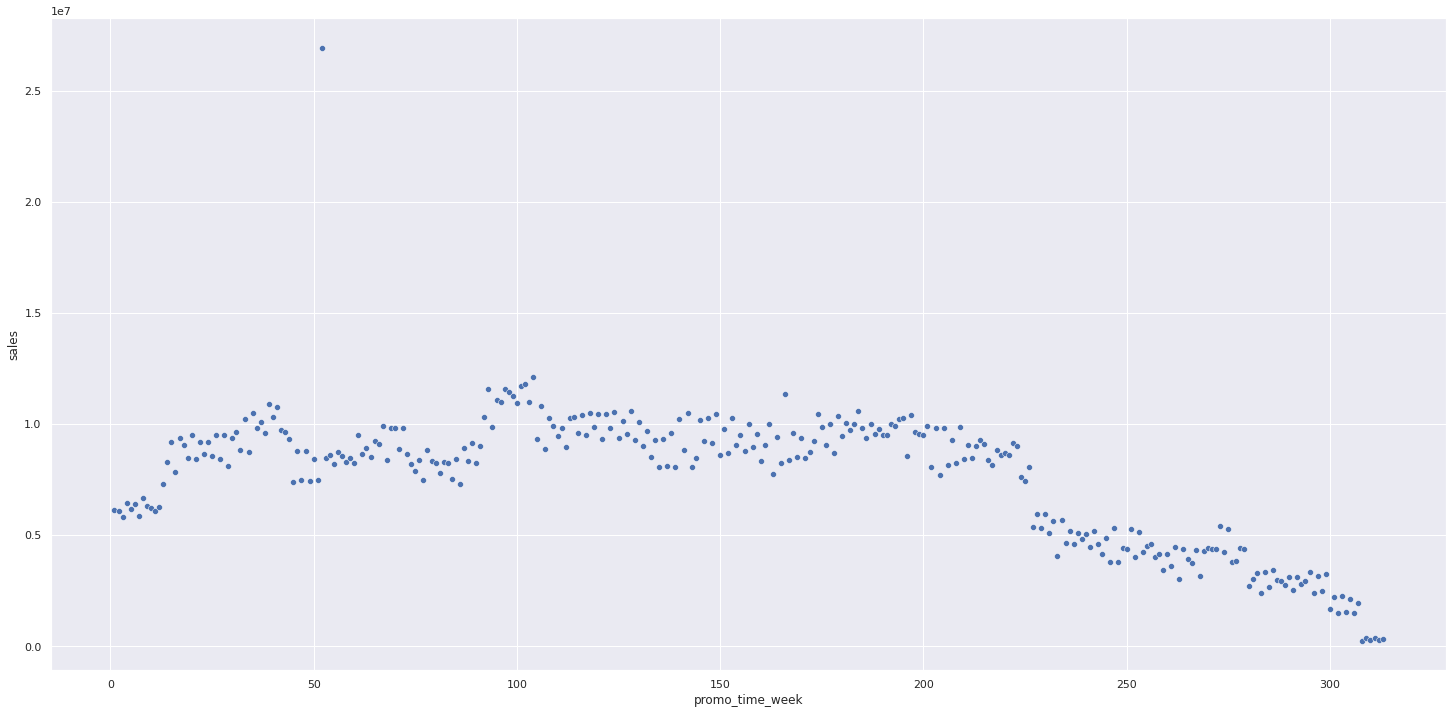

In [76]:
aux1 = df4[['sales', 'promo_time_week']].groupby(by = 'promo_time_week').sum().reset_index()

aux2 = aux1[aux1['promo_time_week'] > 0]

sns.scatterplot(data = aux2, x = 'promo_time_week', y = 'sales')

Perceba que as vendas caem conforme o tempo passa. Portanto, esta hipótese é **FALSA**.

### **Hipótese 5 (FALSA): Lojas com mais promoções consecutivas deveriam vender mais.**

Para verificar esta hipótese, precisamos tanto da coluna `promo` quanto `promo2`, para comparar com as lojas que não tiveram promoções consecutivas. A ideia é fazer um gráfico com das vendas com relação ao tempo.

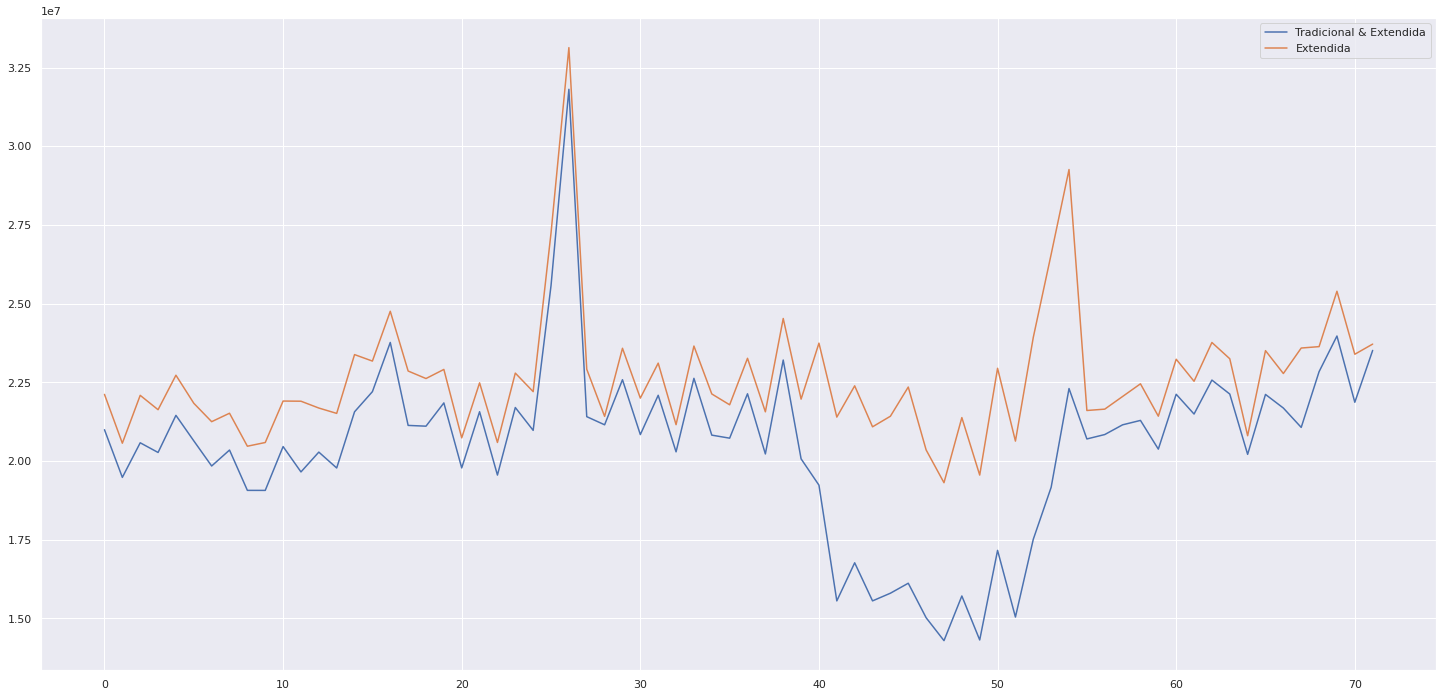

In [77]:
# # Quando tiveram promoções consecutivas
# aux1 = df4[ (df4['promo']==1) & (df4['promo2']==1) ]

# aux1 = df4[['sales', 'year_week']].groupby('year_week').sum().reset_index()
# ax = aux1.plot()

# # # Quando não tiveram promoções consecutivas
# aux2 = df4[ (df4['promo']==1) & (df4['promo2']==0) ]

# aux2 = df4[['sales', 'year_week']].groupby('year_week').sum().reset_index()
# aux2.plot(ax = ax)

# ax.legend( labels=['Tradicional & Extendida', 'Extendida'])

#--------------------------------------------------------------------------------------

aux1=df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2=df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tradicional & Extendida', 'Extendida'])

Como podemos observar, as lojas que tiveram promoções consecutivas tiveram menos venda ao longo do tempo do que as lojas que não tiveram promoções consecutivas. Portanto, a hipótese é **FALSA**.

### **Hipótese 6 (FALSA): Lojas abertas durante o Natal deveriam vender mais.**

Precisamos da coluna `state_holiday` para verificar esta hipótese. Como o atributo é categórico, então basta criar uma tabela. Como estamos analisando as vendas no Natal, copararemos apenas com outros feriados.

In [78]:
aux = df4[ df4['state_holiday']!= 'regular_day' ]

aux2 = aux[['sales', 'state_holiday', 'year']].groupby(['year','state_holiday']).sum()

aux2

sales
year state_holiday          
2013 christmas        331182
     easter_holiday   454997
     public_holiday  2052408
2014 christmas        360624
     easter_holiday   463353
     public_holiday  2084616
2015 easter_holiday   515394
     public_holiday  1753281

Veja que em todos os anos as vendas no Natal são menores do que em outros feriados. Portanto, a hipótese é **FALSA**.

### **Hipótese 7 (FALSA): Lojas deveriam vender mais ao longo dos anos.**

Neste caso, é necessário a coluna `year`, cujos atributos são numéricos. Contudo, como há somente 3 anos a serem vistos - 2013, 2014 e 2015- então basta realizar uma tabela para verificar a hipótese.

In [79]:
aux = df4[['sales', 'year']].groupby('year').sum()

aux

,sales
year,
2013,2302876084
2014,2180804896
2015,1389499643


Perceba que as vendas caíram ao longo dos anos. Portanto, esta hipótese é **FALSA**.

### **Hipótese 8 (FALSA): Lojas deveriam vender mais no segundo semestre do ano.**

Assim como a coluna `year`, a coluna `month` também é numérica. Mas nesse caso é melhor fazer um gráfico de barras do que apenas uma tabela pois temos 12 valores possíveis, enquanto que no caso anterior tínhamos apenas 3.

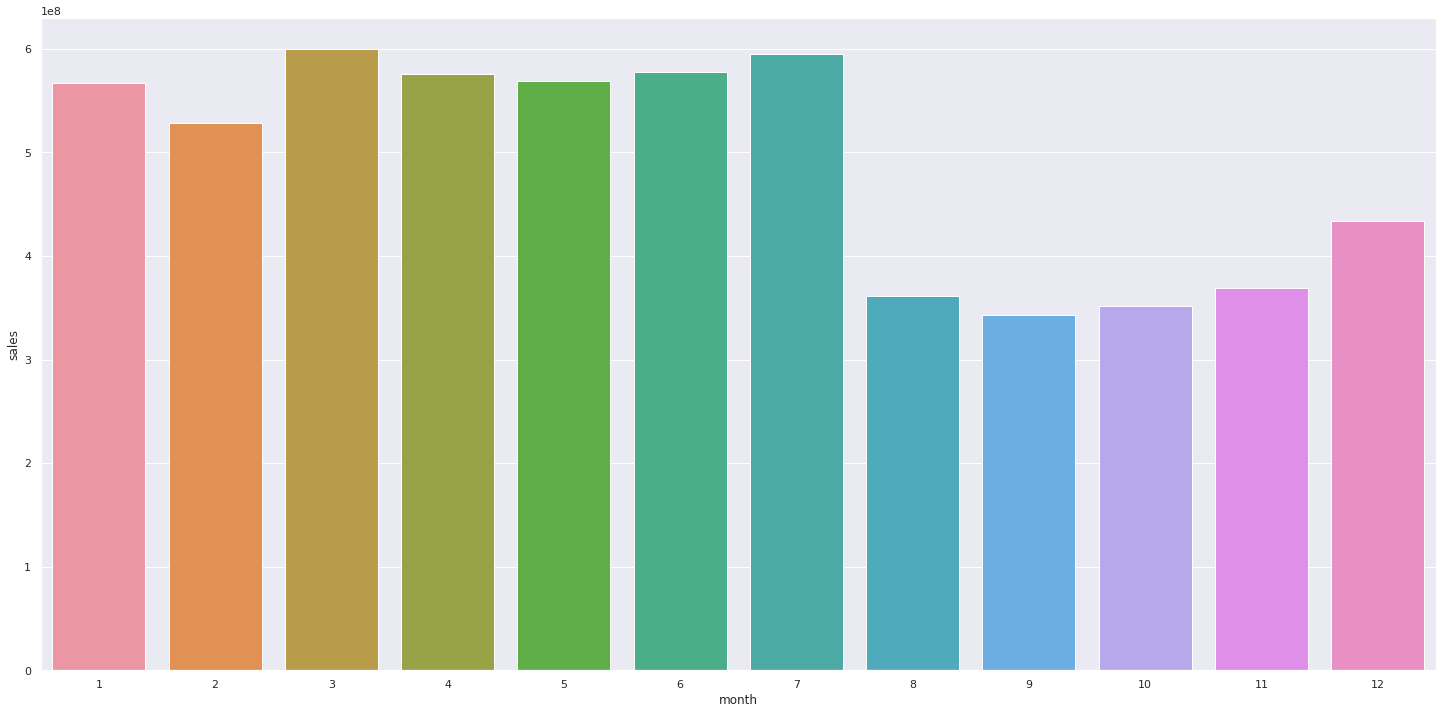

In [80]:
aux = df4[['sales','month']].groupby('month').sum().reset_index()

sns.barplot(data = aux, x = 'month', y = 'sales')

Note que Julho é o único mês do segundo semestre cujas vendas são superiores do que nos meses do primeiro semestre. Portanto, a hipótese é **FALSA**.

### **Hipótese 9 (VERDADEIRA): Lojas vendem mais depois do dia 10 de cada mês.**

Procederemos da mesma maneira que na hipótese anterior, mas com a coluna `day`.

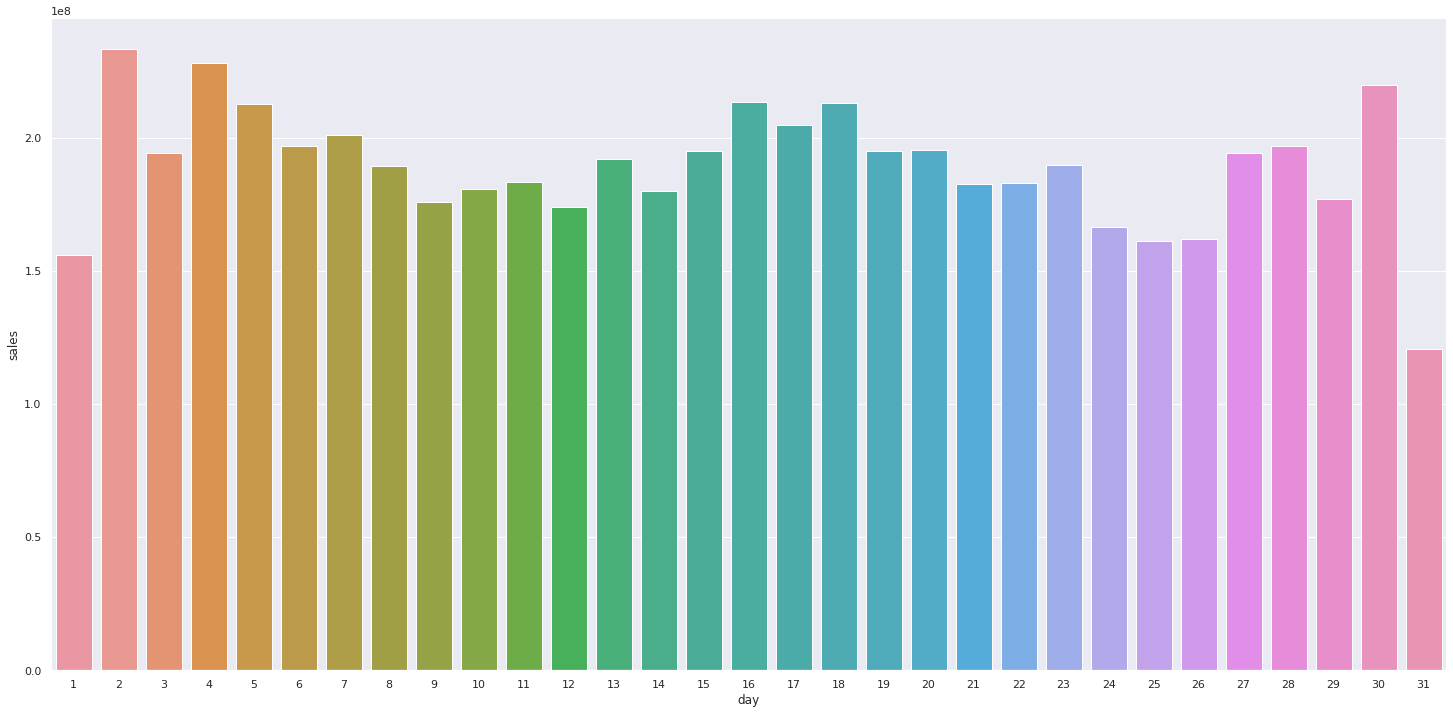

In [81]:
aux = df4[['sales', 'day']].groupby('day').sum().reset_index()

sns.barplot(data = aux, x = 'day', y = 'sales')

Como podemos ver, apenas 6 dias depois do dia 10 possui uma venda inferior. Portanto, esta hipótese é **VERDADEIRA**.

### **Hipótese 10 (VERDADEIRA): As drogarias vendem menos aos finais de semana.**

A coluna `day_of_week` será usada para verificar a hipótese. Faremos isso também com um gráfico de barras.

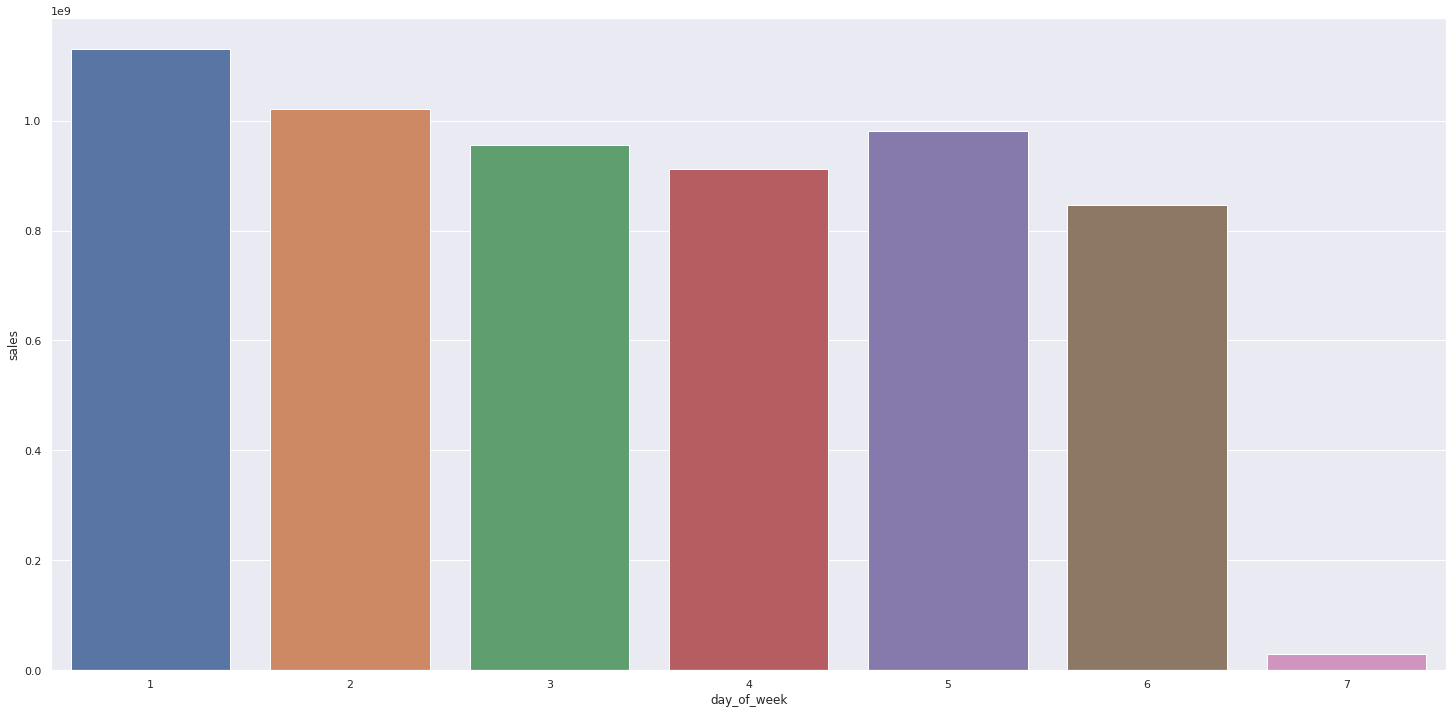

In [82]:
aux = df4[['sales', 'day_of_week']].groupby('day_of_week').sum().reset_index()

sns.barplot(data = aux, x = 'day_of_week', y = 'sales')

De fato, as vendas caem drasticamente aos finais de semana. Portanto, esta hipótese é **VERDADEIRA**.

### **Hipótese 11 (VERDADEIRA): Lojas vendem menos em feriados escolares.**

Aqui devemos agrupar primeiramente os dados tanto pela coluna `school_holiday`, que assume valores 0 ou 1, quanto `month`, para ver a variação das vendas ao longo dos meses quando há e quando não há feriados escolares.

In [83]:
aux = df4[['sales','school_holiday','month']].groupby(by = ['month', 'school_holiday']).sum()

aux.head()

sales
month school_holiday           
1     0               490739687
      1                75989037
2     0               476170426
      1                52563984
3     0               529719808

Agora sim podemos realizar o gráfico de barras sobre.

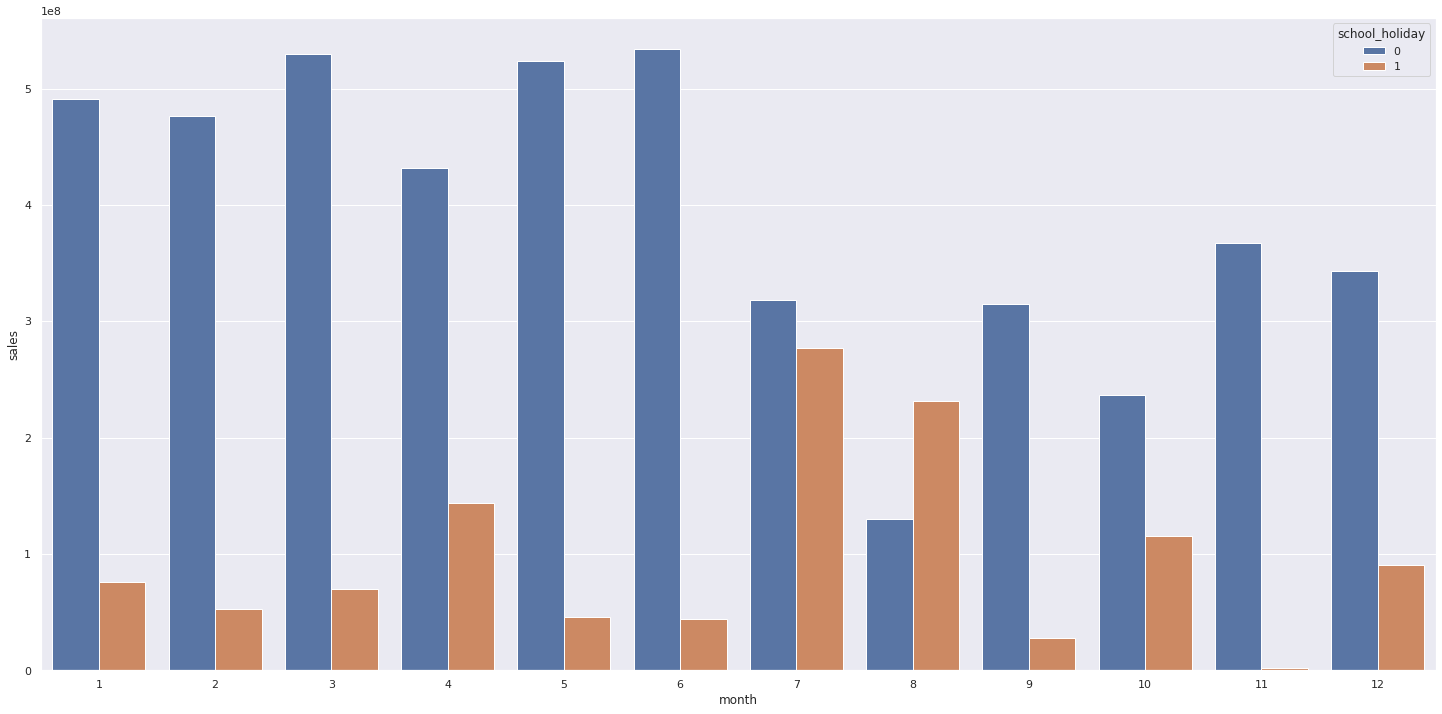

In [84]:
aux = aux.reset_index()

sns.barplot(data = aux, x = 'month', y = 'sales', hue = 'school_holiday')

Como podemos ver, de fato as vendas caem quando há feriados escolares, exceto em Agosto (provavelmente porque é período de férias escolares). Portanto, nossa hipótese é **VERDADERIA**.

## **Análise Multivariada**

Vejamos as correlações entre os atributos numéricos.

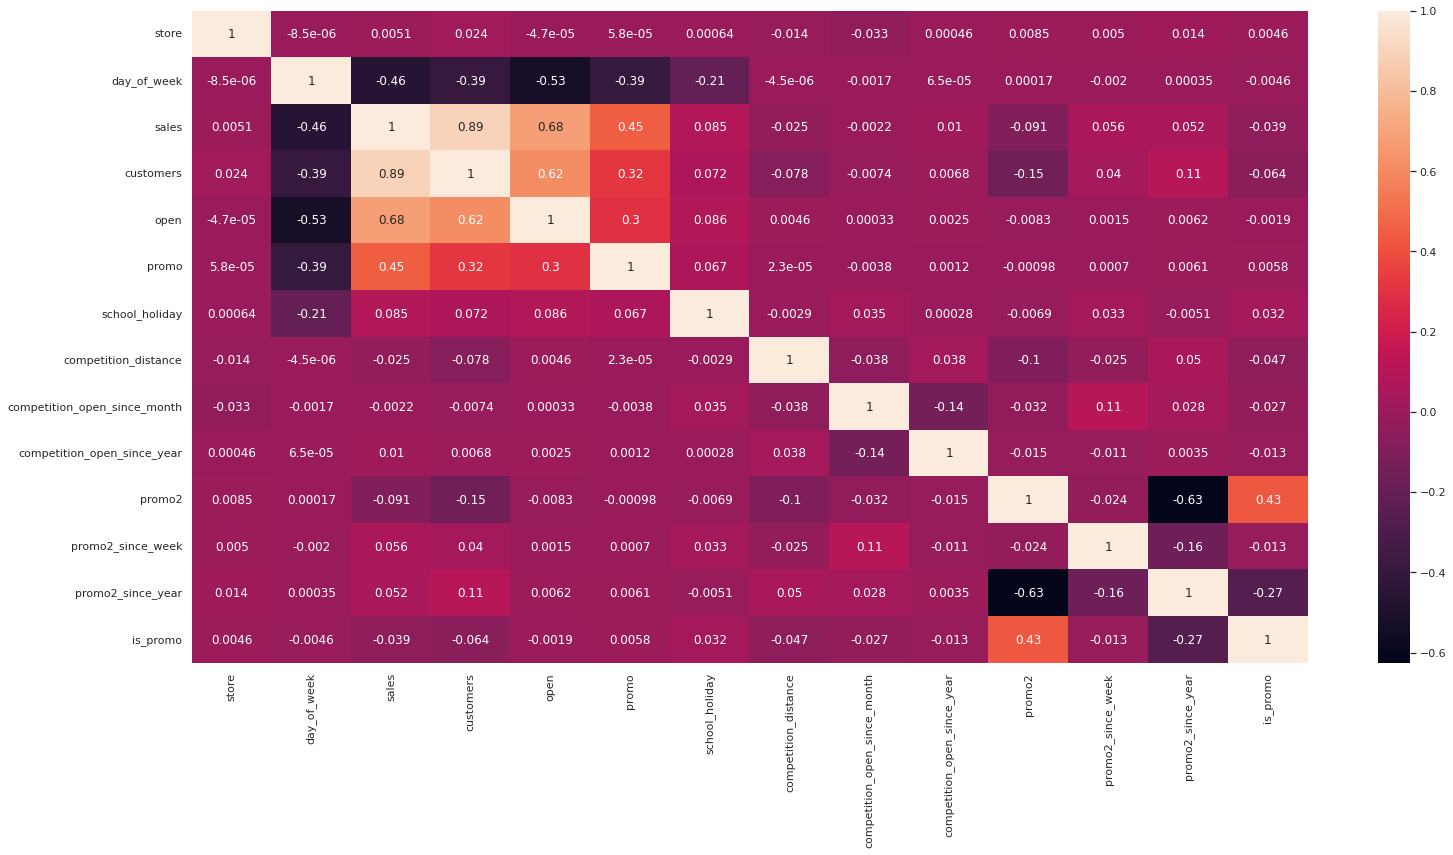

In [85]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

# **PARTE 5: PREPARAÇÃO DOS DADOS**

Assim como nos outros módulos, comecemos fazendo uma cópia dos dados.

In [86]:
df5 = df4.copy()

## **Reescalonamento**

Como vimos nas seções anteriores, as colunas `competition_distance` e `competition_time_month` possuem pontos fora da curva. Por essa razão usaremos o `RobustScaler()` para mudar sua escala. Já com relação às colunas `promo_time_week` e `year`, por terem uma escala diferente das outras colunas, usaremos o `MinMaxScaler()`. Depois disso, salvaremos esses dados de forma compacta com a biblioteca `pickle`.

In [87]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open( 'competition_distance_scaler.pkl', 'wb') )

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump( rs, open( 'competition_time_month_scaler.pkl', 'wb') )

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump( rs, open( 'promo_time_week_scaler.pkl', 'wb') )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump( mms, open( 'year_scaler.pkl', 'wb') )

## **Transformação**

### **Codificação de Categorias**

Agora que fizemos um reescalonamento de algumas colunas cujos atributos são numéricos, vejamos como transformar atributos categóricos. É bem sabido que os algoritmos de aprendizado de máquina processam melhor informações que estão em forma numérica do que em string.

Tendo isso em vista, usaremos a função `get_dummies` do pandas para transformar a coluna `state_holiday` em números dado que essa coluna tem mais de 2 tipos.

In [88]:
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

Para a coluna `store_type`, note que temos 4 tipos:

In [89]:
df5['store_type'].unique()

array(['c', 'a', 'd', 'b'], dtype=object)

Assim, seria melhor empregar a mesma função de antes, mas aqui será usado a classe `LabelEncoder()` apenas para vermos como será o comportamento dos algortimos de machine learning. O método `fit_transform()` da classe `LabelEncoder()` transformará cada "resposta" dessas colunas num número diferente, enquanto que o `get_dummies()` transforma cada string num "vetor" distinto.

In [90]:
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open( 'store_type_scaler.pkl', 'wb') )

Com respeito à coluna `assortment`, também temos mais de um tipo de sortimento:

In [91]:
df5['assortment'].unique()

array(['basic', 'extended', 'extra'], dtype=object)

Nesse caso, apenas atribuiremos "1" para a "basic", "2" para "extra" e "3" para "extended" através de um dicionário. Isso se deve pois de fato aqui podemos estabelecer uma relação de ordem nessas categorias.

In [92]:
assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}

df5['assortment'] = df5['assortment'].map( assortment_dict )

### **Transformação da variável de resposta**

A variável de resposta do nosso caso é a coluna `sales`, que é um atributo numérico. Para que ele não fique com a escala muito distinta das demais colunas, calcularemos o logaritmo natural acrescido de uma unidade para diminuir sua escala. Obs: o "+1" no logartimo serve para evitar de calcular a função na origem, pois log(0) não é definido.

In [93]:
df5['sales'] = np.log1p( df5['sales'] )

## **Mudança nas variáveis temporais**

Aqui criaremos novas colunas que serão o seno e o cosseno das colunas associadas aos dias da semana, dia do mês, etc. A ideia de fazer isso é reter a informação de que, por exemplo, o mês 1 é próximo do mês 12, dado que logo depois de dezembro, vem janeiro. A mesma linha de raciocínio pode ser aplicada às outras marcações de tempo, como os dias da semana: sábado (dia 7) é sucedido por domingo (dia 1).

Para o caso do dia da semana, devemos multiplicar cada dia por um fator de $(2 \pi)/ 7$ pois a semana tem 7 dias. 

In [94]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

Como o ano tem 12 meses, então o fator é de $(2 \pi)/12$.

In [95]:
# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

Procedendo da mesma maneira com o dia do mês e a semana do ano, temos:

In [96]:
# day 
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

# **PARTE 6: SELEÇÃO DAS CARACTERÍSTICAS**

Comecemos realizando uma cópia como de costume.

In [97]:
df6 = df5.copy()

Como o próprio nome já diz, vamos aqui selecionar as colunas mais relevantes para treinar os modelos de aprendizado de máquina. Na parte anterior, criamos novas colunas com relação ao tempo a fim de dar a ideia de que os dias da semana, mês e do ano são cíclicos. Deste modo, não precisamos mais das colunas originais de marcação de tempo.

In [98]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week' ]

df6 = df6.drop(columns = cols_drop)

## **Particionamento de treino e teste**

Como temos um grande volume de dados, alocaremos 95% dos dados para treinar o modelo, e 5% para testar sua performance (pois correspondem às últimas 6 semanas de vendas).

In [99]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## **Usando o Boruta para selecionar as melhores características**

Para usar o Boruta, vamos transformar a variável de resposta (coluna `sales`) num array, que é feito com o método `ravel()`. Além disso, retiraremos as colunas `date` e `sales` do treino.

In [100]:
# training and test dataset for Boruta
X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
y_train_n = y_train.values.ravel()

Um dos modelos a serem implementados é o de floresta aleatória. Deste modo, criaremos uma instância da classe `RandomForestRegressor`, que também entrará como argumento no boruta.

In [101]:
# define RandomForestRegressor
rf = RandomForestRegressor( n_jobs=-1 )

Aqui coloquei `n_jobs = -1` para que o modelo rode todas as tarefas em paralelo.

In [102]:
# define Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

In [103]:
# cols_selected = boruta.support_.tolist()

# # best features
# X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# # not selected boruta
# cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

## **Seleção manual de atributos**

In [104]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
# isso é pra validação cruzada de dados
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# **PARTE 7: APLICAÇÃO DOS MODELOS DE MACHINE LEARNING**

## **Introdução**

Antes de implementar os modelos de aprendizado de máquina, vamos separar o bloco dos dados que serão usado como treino e como teste, só que agora selecionando apenas as colunas mais relevantes.

In [105]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
# Isso é pra validação de dados cruzadas
x_training = X_train[ cols_selected_boruta_full ]

## **Modelo de médias**

Como primeiro modelo, vamos dizer que os valores de venda serão simplesmente a média das vendas de suas respectivas lojas. 

A ideia de implementar a média é usá-la como modelo de base para os outros métodos. Por exemplo, se uma rede neural teve uma precisão menor que o modelo de média, então dizemos que não foi uma boa escolha usá-la.

In [106]:
aux1 = x_test.copy()

aux1['sales'] = y_test.copy()

Para tal, basta usar o método `groupby()`, agrupando por lojas, e depois aplicando o método `mean()` para obter as médias.

In [107]:
objeto = aux1[['store', 'sales']].groupby( 'store' )

aux2 = objeto.mean()

aux2.sample(5)

,sales
store,
79,8.625278
320,9.607652
1036,8.505188
374,8.833489
243,8.778646


Vamos resetar os índices para recuperar o nome da coluna, e mudar o nome `sales` para `predictions`, pois esses valores são justamente as previsões de venda para cada loja.

In [108]:
aux2 = aux2.reset_index().rename( columns={'sales': 'predictions'} )

aux2.sample(5)

,store,predictions
879,880,8.986413
641,642,8.059780
521,522,9.065676
1113,1114,10.023617
742,743,8.185215


Note que o número de linhas já não é mais o mesmo do que o conjunto de testes, pois foi aplicado uma função em cada tipo de loja.

In [109]:
aux2.shape

(1115, 2)

Como queremos associar nossas previsões com os dados iniciais, que possui muito mais linhas, então devemos fazer uma junção dessas duas tabelas, usando como chave a coluna "store".

In [110]:
aux1 = pd.merge( aux1, aux2, how='left', on='store' )

Agora sim podemos separar a coluna contendo todas as respostas na ordem que foi dada.

In [111]:
yhat_baseline = aux1['predictions']

yhat_baseline.sample(5)

18063    8.517611
26165    7.977372
27297    9.187316
37622    8.622497
8997     8.737875
Name: predictions, dtype: float64

### **Performance**

Uma vez implantado o modelo, calculemos os erros MAE, RMSE e MAPE com a função `ml_error()` definida nas primeiras seções.

In [112]:
# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


Obs: Usamos a função `expm1()` do numpy, que calcula $e^x -1$, para voltar aos dados originais, dado que alteramos a escala na etapa anterior com a função $log (1+x)$.

## **Regressão Linear**

Feito o modelo de média, apliquemos a regressão linear simples no nosso conjunto de treino.

In [113]:
# model
lr = LinearRegression()
lr.fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

### **Performance**

Procedendo da mesma maneira para calcular a performance do modelo, temos

In [114]:
# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


Embora o erro percentual esteja melhor do que em relação ao modelo anterior, o erro quadrático médio é consideravelmente maior. Deste modo, a regressão linear simples é pior que o modelo de médias.

### **Validação Cruzada**

Vejamos a validação cruzada da regressão linear.

In [115]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## **LASSO**

Feito uma regressão linear simples, apliquemos agora o modelo LASSO (least absolute shrinkage and selection operator), que é um tipo de regressão mais aprimorado.

In [116]:
# model
lrr = Lasso( alpha=0.01 )

lrr.fit( x_train, y_train )

Lasso(alpha=0.01)

Assim como na regressão linear, as previsões são feitas com o método `predict()`.

In [117]:
# prediction
yhat_lrr = lrr.predict( x_test )

### **Performance**

Para sabermos a performance do modelo, procedemos da mesma maneira com relação às seções anteriores.

In [118]:
# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


Tendo o fato de que os erros RMS, tanto na regressão linear quanto regressão linear regularizada, são piores que no modelo de média simples, então podemos dizer que o conjunto de dados que estamos trabalhando não possui um comportamento linear.

Portanto, os modelos implementados nas seções seguintes serão não-lineares a fim de obter uma performance melhor.

### **Validação Cruzada**

Fazendo a validação cruzada do LASSO, temos

In [119]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## **Random Forest**

Agora vamos executar o modelo de floresta aleatória, colocando como parâmetro 100 árvores.

In [120]:
# # model
# rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 )

# rf.fit( x_train, y_train )


# # prediction
# yhat_rf = rf.predict( x_test )

### **Performance**

Feito isso, vejamos qual é a performance gerada com esse número de árvores.

In [121]:
# # performance
# rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
# rf_result

### **Validação Cruzada**

Para a validação cruzada da floresta aleatória, colocaremos `verbose=True` para vermos o andamento de cada iteração dado que este modelo é mais demorado em termos de processamento.

In [122]:
# rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
# rf_result_cv

## **XGBoost**

Para finalizar, vamos executar o modelo XGBoost, que também é não-linear.

In [123]:
# # model
# model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                               n_estimators=100, 
#                               eta=0.01, 
#                               max_depth=10, 
#                               subsample=0.7,
#                               colsample_bytee=0.9 )

# model_xgb.fit( x_train, y_train )

# # prediction
# yhat_xgb = model_xgb.predict( x_test )

### **Performance**

Avaliando a performance, temos

In [124]:
# # performance
# xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
# xgb_result

### **Validação Cruzada**

Procedendo da mesma maneira que nos outros modelos, calculemos a real performance do XGBoost.

In [125]:
# xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
# xgb_result_cv

## **Comparação dos modelos**

Vamos aqui concatenar os resultados dos modelos implementados numa única tabela.

In [126]:
# modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
# modelling_result.sort_values( 'RMSE' )

### **Comparação das validações cruzadas**

Concatenando os resultados das validações cruzadas, temos

In [127]:
# modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
# modelling_result_cv

Embora o modelo de floresta aleatória tenha a melhor performance, prosseguiremos com o XGBoost pois seu custo computacional é menor, e também porque será mais conveniente usá-lo na próxima seção, ajuste fino de hiperparâmetros, dado que seus parâmetros podem ser ajustados de uma maneira mais manual do que no modelo de floresta aleatória.

# **PARTE 8: AJUSTE FINO DE HIPERPARÂMETROS**

Aqui iremos fazer o ajuste de parâmetros do modelo XGBoost de maneira aleatória devido ao seu menor custo computacional do que de em relação ao "grid search" e ao "Baysean search".

Para isso, criemos um dicionário contendo o nome dos parâmetros que iremos configurar, com a lista de alguns valores que esses parâmetros podem assumir.

In [128]:
param = {
   'n_estimators': [1500, 1700, 2500, 3000, 3500],
   'eta': [0.01, 0.03],
   'max_depth': [3, 5, 9],
   'subsample': [0.1, 0.5, 0.7],
   'colsample_bytree': [0.3, 0.7, 0.9],
   'min_child_weight': [3, 8, 15]
       }

MAX_EVAL = 5

Obs: a variável `MAX_EVAL` é o número de vezes que iremos percorrer um laço `for` para a procura aleatória.

In [129]:
# final_result = pd.DataFrame()

# hp = {}

# for i in range( MAX_EVAL ):

#   # choose values for parameters randomly
#   for chave in param.keys():

#     lista1 = param.get(chave)

#     lista2 = random.sample(lista1,1)

#     ElementoAleatorio = lista2[0]

#     hp.update({chave:ElementoAleatorio})

   
#   print( hp )
   
#    # model
#   model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                  n_estimators=hp['n_estimators'], 
#                                  eta=hp['eta'], 
#                                  max_depth=hp['max_depth'], 
#                                  subsample=hp['subsample'],
#                                  colsample_bytee=hp['colsample_bytree'],
#                                  min_child_weight=hp['min_child_weight'] )

#    # performance
#   result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
#   final_result = pd.concat( [final_result, result] )
       

A tabela com o resultado é a seguinte:

In [130]:
# final_result

Para não ter que rodar esse laço da escolha aleatória, vamos salvar os resultados num novo dicionário.

In [131]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3 
        }

Agora sim vamos executar o ajuste fino de hiperparâmetros.

In [132]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    eta=param_tuned['eta'], 
                                    max_depth=param_tuned['max_depth'], 
                                    subsample=param_tuned['subsample'],
                                    colsample_bytee=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )

xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,664.974997,0.097529,957.774225


# **PARTE 9: TRADUÇÃO E INTERPRETAÇÃO DO ERRO**

Para começar, criemos uma tabela contendo os dados de teste, incluindo o as previsões de vendas.

In [133]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Obs: Aqui usamos a função exponencial para que voltemos à escala original, dado que havíamos aplicado o logaritmo anteriormente.

## **Performance de Negócio**

Antes de comparar os diferentes cenários, devemos agrupar os dados por suas lojas, e somar o faturamento para cada unidade na coluna de previsões.

In [134]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

Agora calculemos o erro médio absoluto e percentual.

In [135]:
# MAE and MAPE

objeto = df9[['store', 'sales', 'predictions']].groupby( 'store' )


df9_aux1 = objeto.apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) )

df9_aux1 = df9_aux1.reset_index().rename( columns={0:'MAE'})



df9_aux2 = objeto.apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) )

df9_aux2 = df9_aux2.reset_index().rename( columns={0:'MAPE'})

Fazendo uma junção interna das duas tabelas, temos

In [136]:
# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )

df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

Assim, para sabermos o resultado das vendas para o melhor e pior cenário, basta somar ou subtrair o erro MAE das previsões.

In [137]:
# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

Ordenando as colunas da maneira abaixo, e depois as linhas de acordo com o erro percentual, temos.

In [138]:
# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

df92.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,104033.085938,100714.981535,107351.190340,3318.104402,0.565828
908,909,238233.875000,230573.337254,245894.412746,7660.537746,0.520433
875,876,203030.156250,199110.952414,206949.360086,3919.203836,0.305099
721,722,353005.781250,351013.625119,354997.937381,1992.156131,0.268338
594,595,400883.625000,397415.263170,404351.986830,3468.361830,0.242192


Feito isso, vejamos qualitativamente se há muitas lojas que possuem um erro absoluto percentual médio grande.

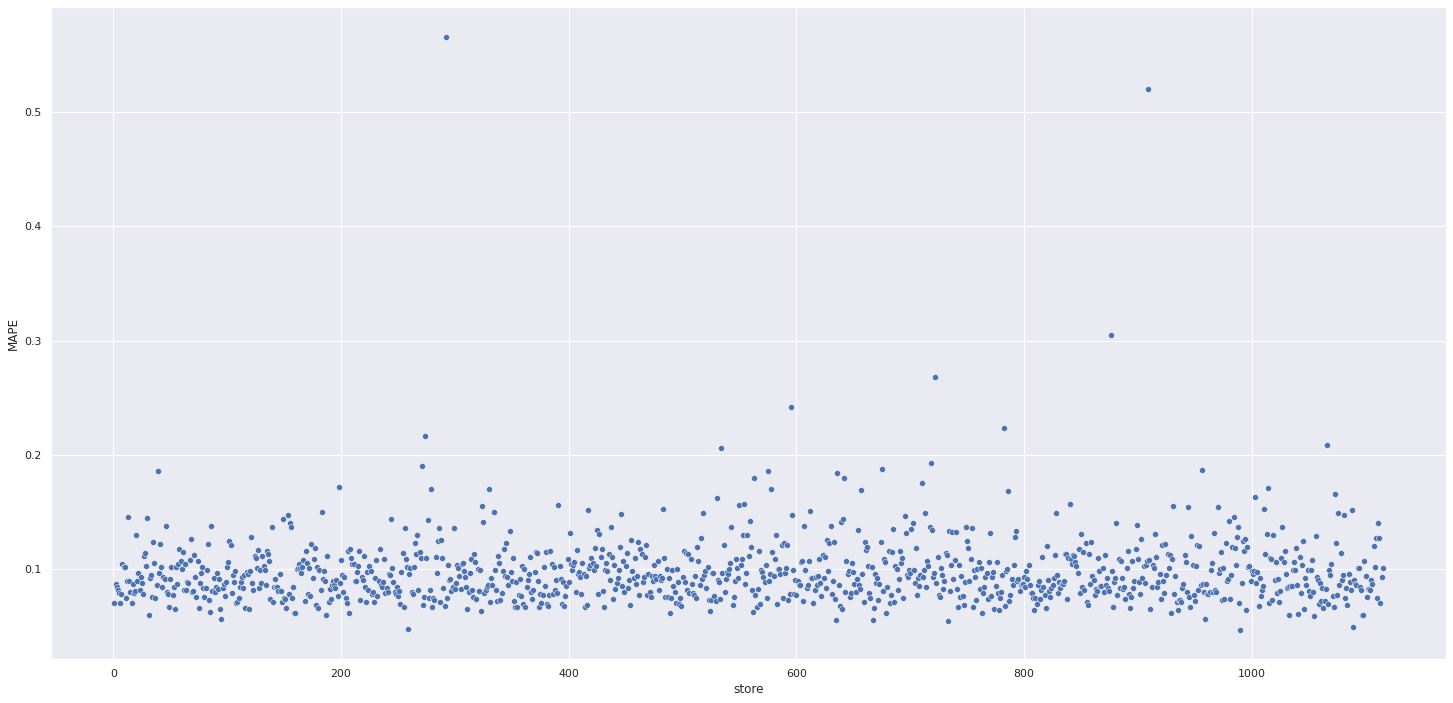

In [139]:
sns.scatterplot( x='store', y='MAPE', data=df92 )

Note que boa parte das lojas está com erro menor que 20%.

## **Performance Total**

Somemos as previsões de venda de todas as lojas durante todo o período.

In [140]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )

df93

,Scenario,Values
0,predictions,2.858605e+08
1,worst_scenario,2.851150e+08
2,best_scenario,2.866060e+08


## **Performance do Modelo**

Por fim, vejamos a performance do modelo de aprendizado de máquina com alguns gráficos.

In [141]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


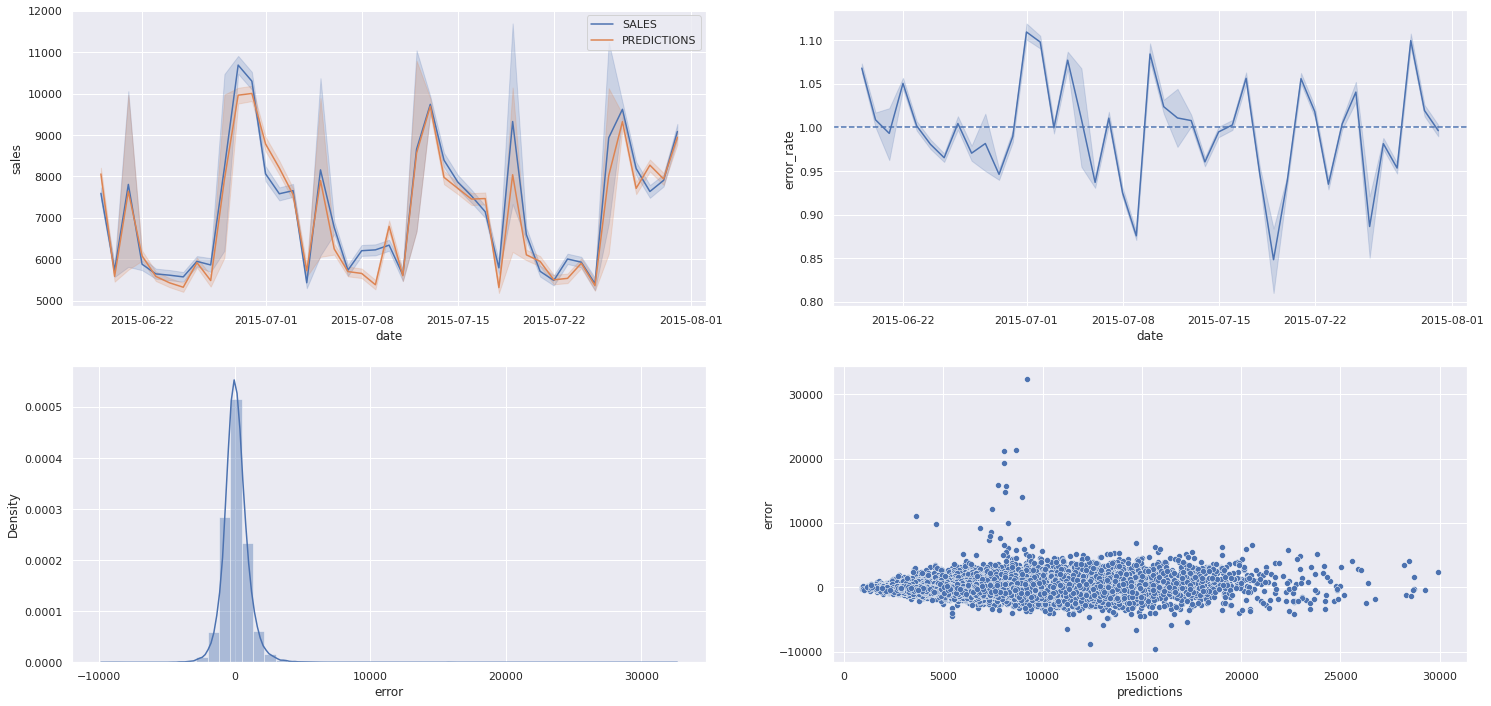

In [142]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] )